# NicheCompass Data Analysis

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 02.06.2023

- In order to run this notebook, a trained model needs to be stored under f"../artifacts/{dataset}/models/{load_timestamp}/{model_label}".

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import argparse
import os
import random
import warnings
from datetime import datetime
import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.stats as stats
import seaborn as sns
import squidpy as sq
import torch
from matplotlib import gridspec
from matplotlib.pyplot import rc_context

sys.path.append("/Users/irene.bonafonte/Documents/PhD/Software/nichecompass/")
from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_ligand_target_mx,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                get_unique_genes_from_gp_dict)

sys.path.append("/Users/irene.bonafonte/Documents/PhD/Projects/2023May_nincheCampus/nichecompass-reproducibility/utils")
from color_utils import (batch_colors,
                         latent_cluster_colors,
                         mapping_entity_colors,
                         seqfish_mouse_organogenesis_cell_type_colors,
                         spatial_atac_rna_seq_mouse_embryo_and_brain_rna_colors,
                         spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors,
                         starmap_plus_mouse_cns_cell_type_colors,
                         visium_human_heart_colors)
from analysis_utils import (add_cell_type_latent_cluster_emphasis,
                            add_sub_cell_type,
                            compute_cell_type_latent_clusters,
                            generate_gp_info_plots,
                            plot_physical_latent_for_cell_types,
                            plot_cell_type_latent_clusters,
                            plot_latent,
                            plot_latent_clusters_in_latent_and_physical_space,
                            store_top_gps_summary)

ModuleNotFoundError: No module named 'decoupler'

### 1.2 Define Parameters

In [5]:
# dataset = "spatial_atac_rna_seq_mouse_brain_batch2"
# dataset = "seqfish_mouse_organogenesis_imputed"
# dataset = "vizgen_merfish_human_colon_cancer"
dataset = "nanostring_cosmx_human_nsclc"

#### 1.2.1 Generic Parameters

In [6]:
## Model
# AnnData keys
adj_key = "spatial_connectivities"
spatial_key = "spatial"
sub_cell_type_key = "sub_cell_type"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
latent_key = "nichecompass_latent"
mapping_entity_key = "mapping_entity"

## Others
random_seed = 0

#### 1.2.2 Dataset-specific Parameters

In [7]:
if dataset == "seqfish_mouse_organogenesis_imputed":
    load_timestamp = "12052023_101740"
    load_timestamp = "02062023_130713"
    model_label = "one-hop-norm_reference"
    #model_label = "one-hop-norm_reference_query"
    counts_key = "log_normalized_counts"
    cell_type_key = "celltype_mapped_refined"
    cell_type_colors = seqfish_mouse_organogenesis_cell_type_colors
    dataset_str = "seqFISH Mouse Organogenesis Imputed"
    multimodal = False
    sample_key = "sample"
    samples = ["embryo1", "embryo2", "embryo3"]
    condition_key = "batch"
    latent_leiden_resolution = 0.4
    latent_cluster_spot_size = 0.03
elif dataset == "starmap_plus_mouse_cns":
    cell_type_colors = starmap_plus_mouse_cns_cell_type_colors
    dataset_str = "STARmap PLUS Mouse Central Nervous System"
    multimodal = False
elif dataset == "visium_human_heart":
    load_timestamp = "15052023_102158"
    cell_type_key = "majority_cell_type"
    cell_type_colors = visium_human_heart_colors
    dataset_str = "Visium Human Heart"
    multimodal = False
    sample_key = "batch"
    samples = ["batch1", "batch2", "batch3"]
    condition_key = "batch"
    latent_leiden_resolution = 0.5
    latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
    latent_cluster_spot_size = 200
elif dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    load_timestamp = "02062023_151955"
    model_label = "one-hop-norm_reference"
    multimodal = True
    cell_type_key = "RNA_clusters"
    cell_type_colors = spatial_atac_rna_seq_mouse_embryo_and_brain_rna_colors
    rna_cluster_colors = spatial_atac_rna_seq_mouse_embryo_and_brain_rna_colors
    atac_cluster_colors = spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors
    dataset_str = "Spatial ATAC-RNA-Seq Mouse Brain"
    sample_key = "batch"
    samples = ["p22"]
    condition_key = "batch"
    latent_leiden_resolution = 0.6
    latent_cluster_spot_size = 30
    groups = ["7"]
elif dataset == "starmap_plus_mouse_cns":
    load_timestamp = "22052023_134412"
    multimodal = False
elif dataset == "nanostring_cosmx_human_nsclc":
    load_timestamp = "02062023_065414"
    model_label = "one-hop-norm_reference"
    dataset_str = "Nanostring CosMx Human NSCLC"
    condition_key = "sample"
    latent_leiden_resolution = 0.5
    latent_cluster_spot_size = 60
    sample_key = "sample"
    samples = ["lung5_rep1", "lung5_rep2", "lung5_rep3"]
    multimodal = False
elif dataset == "vizgen_merfish_human_colon_cancer":
    load_timestamp = "22052023_132110"
    model_label = "one-hop-norm_reference"
    dataset_str = "Vizgen MERFISH Human Colon Cancer"
    condition_key = "sample"
    sample_key = "batch"
    samples = ["batch1", "batch2"]
    latent_leiden_resolution = 0.5
    latent_cluster_spot_size = 30
    multimodal = False
elif dataset == "vizgen_merfish_human_ovarian_cancer":
    load_timestamp = "22052023_132125"
    multimodal = False
    
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"

### 1.3 Run Notebook Setup

In [8]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [9]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

### 1.4 Configure Paths and Create Directories

In [12]:
# Define paths
figure_folder_path = f"../artifacts/{dataset}/figures/{load_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/models/{load_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Model

### 2.1 Load Model

In [13]:
if model_label == "sample_integration_method_benchmarking":
    model_dir_path = f"{model_artifacts_folder_path}/{model_label}/run{run_number}"
else:
    model_dir_path = f"{model_artifacts_folder_path}/{model_label}"

In [16]:
if multimodal:
    model = NicheCompass.load(dir_path=model_dir_path,
                              adata=None,
                              adata_file_name=f"{dataset}_{model_label}.h5ad",
                              adata_atac=None,
                              adata_atac_file_name=f"{dataset}_{model_label}_atac.h5ad",
                              gp_names_key=gp_names_key)
else:
    # Load trained model
    model = NicheCompass.load(dir_path=model_dir_path,
                              adata=None,
                              adata_file_name=f"{dataset}_{model_label}.h5ad",
                              gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder']
ENCODER -> n_input: 960, n_cond_embed_input: 0, n_layers: 1, n_hidden: 960, n_latent: 1064, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 0, n_cond_embed_output: 1064, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1064, n_cond_embed_input: 960, n_addon_input: 0, n_output: 1920
ONE HOP GCN NORM NODE LABEL AGGREGATOR -> self_loops: True


### 2.2 Retrieve GP Summary

In [18]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 1064.
Number of active gene programs: 1003.


In [19]:
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True][800:820]

gp_name  all_gp_idx  gp_active  active_gp_idx  \
838   LAMA2_ligand_targetgenes_GP         838       True            800   
839   LAMB1_ligand_targetgenes_GP         839       True            801   
840   LAMB2_ligand_targetgenes_GP         840       True            802   
841  LEFTY2_ligand_targetgenes_GP         841       True            803   
842  LRPAP1_ligand_targetgenes_GP         842       True            804   
843     LTF_ligand_targetgenes_GP         843       True            805   
844     MDK_ligand_targetgenes_GP         844       True            806   
845   MMP13_ligand_targetgenes_GP         845       True            807   
846    MMP9_ligand_targetgenes_GP         846       True            808   
847   NAMPT_ligand_targetgenes_GP         847       True            809   
848    NID1_ligand_targetgenes_GP         848       True            810   
849   NLGN1_ligand_targetgenes_GP         849       True            811   
850   NLGN3_ligand_targetgenes_GP         850       True            812   
851   NODAL_ligand_targetgenes_GP         851       True            813   
852     NOV_ligand_targetgenes_GP         852       True            814   
853    NPNT_ligand_targetgenes_GP         853       True            815   
855    NTN1_ligand_targetgenes_GP         855       True            816   
856   NTNG1_ligand_targetgenes_GP         856       True            817   
858   PDGFD_ligand_targetgenes_GP         858       True            818   
859     PF4_ligand_targetgenes_GP         859       True            819   

     n_source_genes  n_non_zero_source_genes  n_target_genes  \
838               0                        0              82   
839               0                        0               1   
840               0                        0               2   
841               1                        1             130   
842               0                        0               3   
843               1                        1              69   
844               0                        0               7   
845               0                        0             121   
846               1                        1              15   
847               0                        0              52   
848               0                        0               2   
849               0                        0              35   
850               0                        0              33   
851               0                        0             109   
852               0                        0              18   
853               0                        0              16   
855               0                        0               3   
856               0                        0               1   
858               1                        1              11   
859               1                        1               4   

     n_non_zero_target_genes gp_source_genes  \
838                       82              []   
839                        1              []   
840                        2              []   
841                      130        [LEFTY2]   
842                        3              []   
843                       69           [LTF]   
844                        7              []   
845                      121              []   
846                       15          [MMP9]   
847                       52              []   
848                        2              []   
849                       35              []   
850                       33              []   
851                      109              []   
852                       18              []   
853                       16              []   
855                        3              []   
856                        1              []   
858                       11         [PDGFD]   
859                        4           [PF4]   

                                       gp_target_genes  \
838  [OLFM4, TACSTD2, DMBT1, CD48, PSC

## 3. Analysis

### 3.1 Analyze Latent Manifold

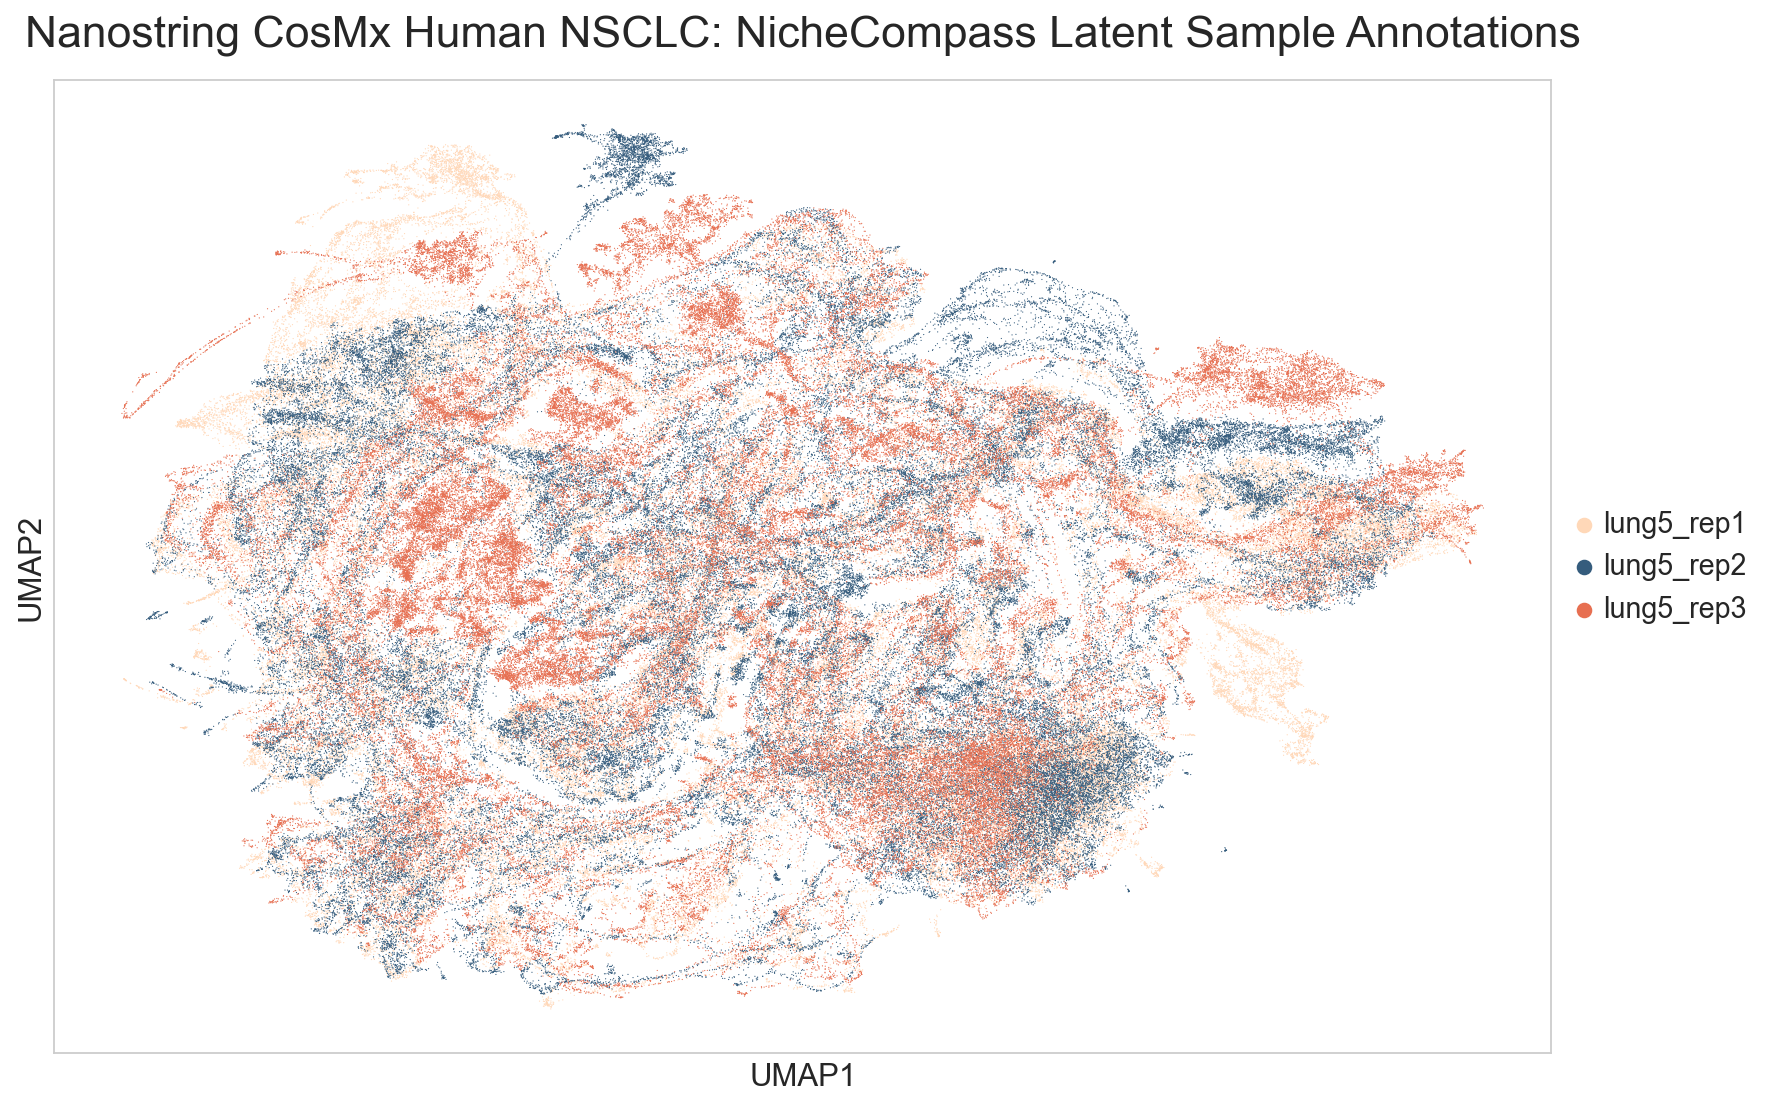

In [20]:
# Plot UMAP with batch annotations
save_fig = True
file_path = f"{figure_folder_path}/batch_annotations_latent_space.svg"

plot_latent(adata=model.adata,
            dataset_label=dataset_str,
            color_by=condition_key,
            color_palette=batch_colors,
            groups=None,
            save_fig=save_fig,
            file_path=file_path)

In [ ]:
# Plot UMAP with cell type annotations
save_fig = True
file_path = f"{figure_folder_path}/cell_type_annotations_latent_space.svg"

plot_latent(adata=model.adata,
            dataset_label=dataset_str,
            color_by=cell_type_key,
            color_palette=cell_type_colors,
            groups=None,
            save_fig=save_fig,
            file_path=file_path)

In [ ]:
# Plot UMAP with mapping entity annotations
save_fig = True
file_path = f"{figure_folder_path}/mapping_entity_annotations_latent_space.svg"

plot_latent(adata=model.adata,
            dataset_label=dataset_str,
            color_by=mapping_entity_key,
            color_palette=mapping_entity_colors,
            groups=None,
            save_fig=save_fig,
            file_path=file_path)

In [22]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

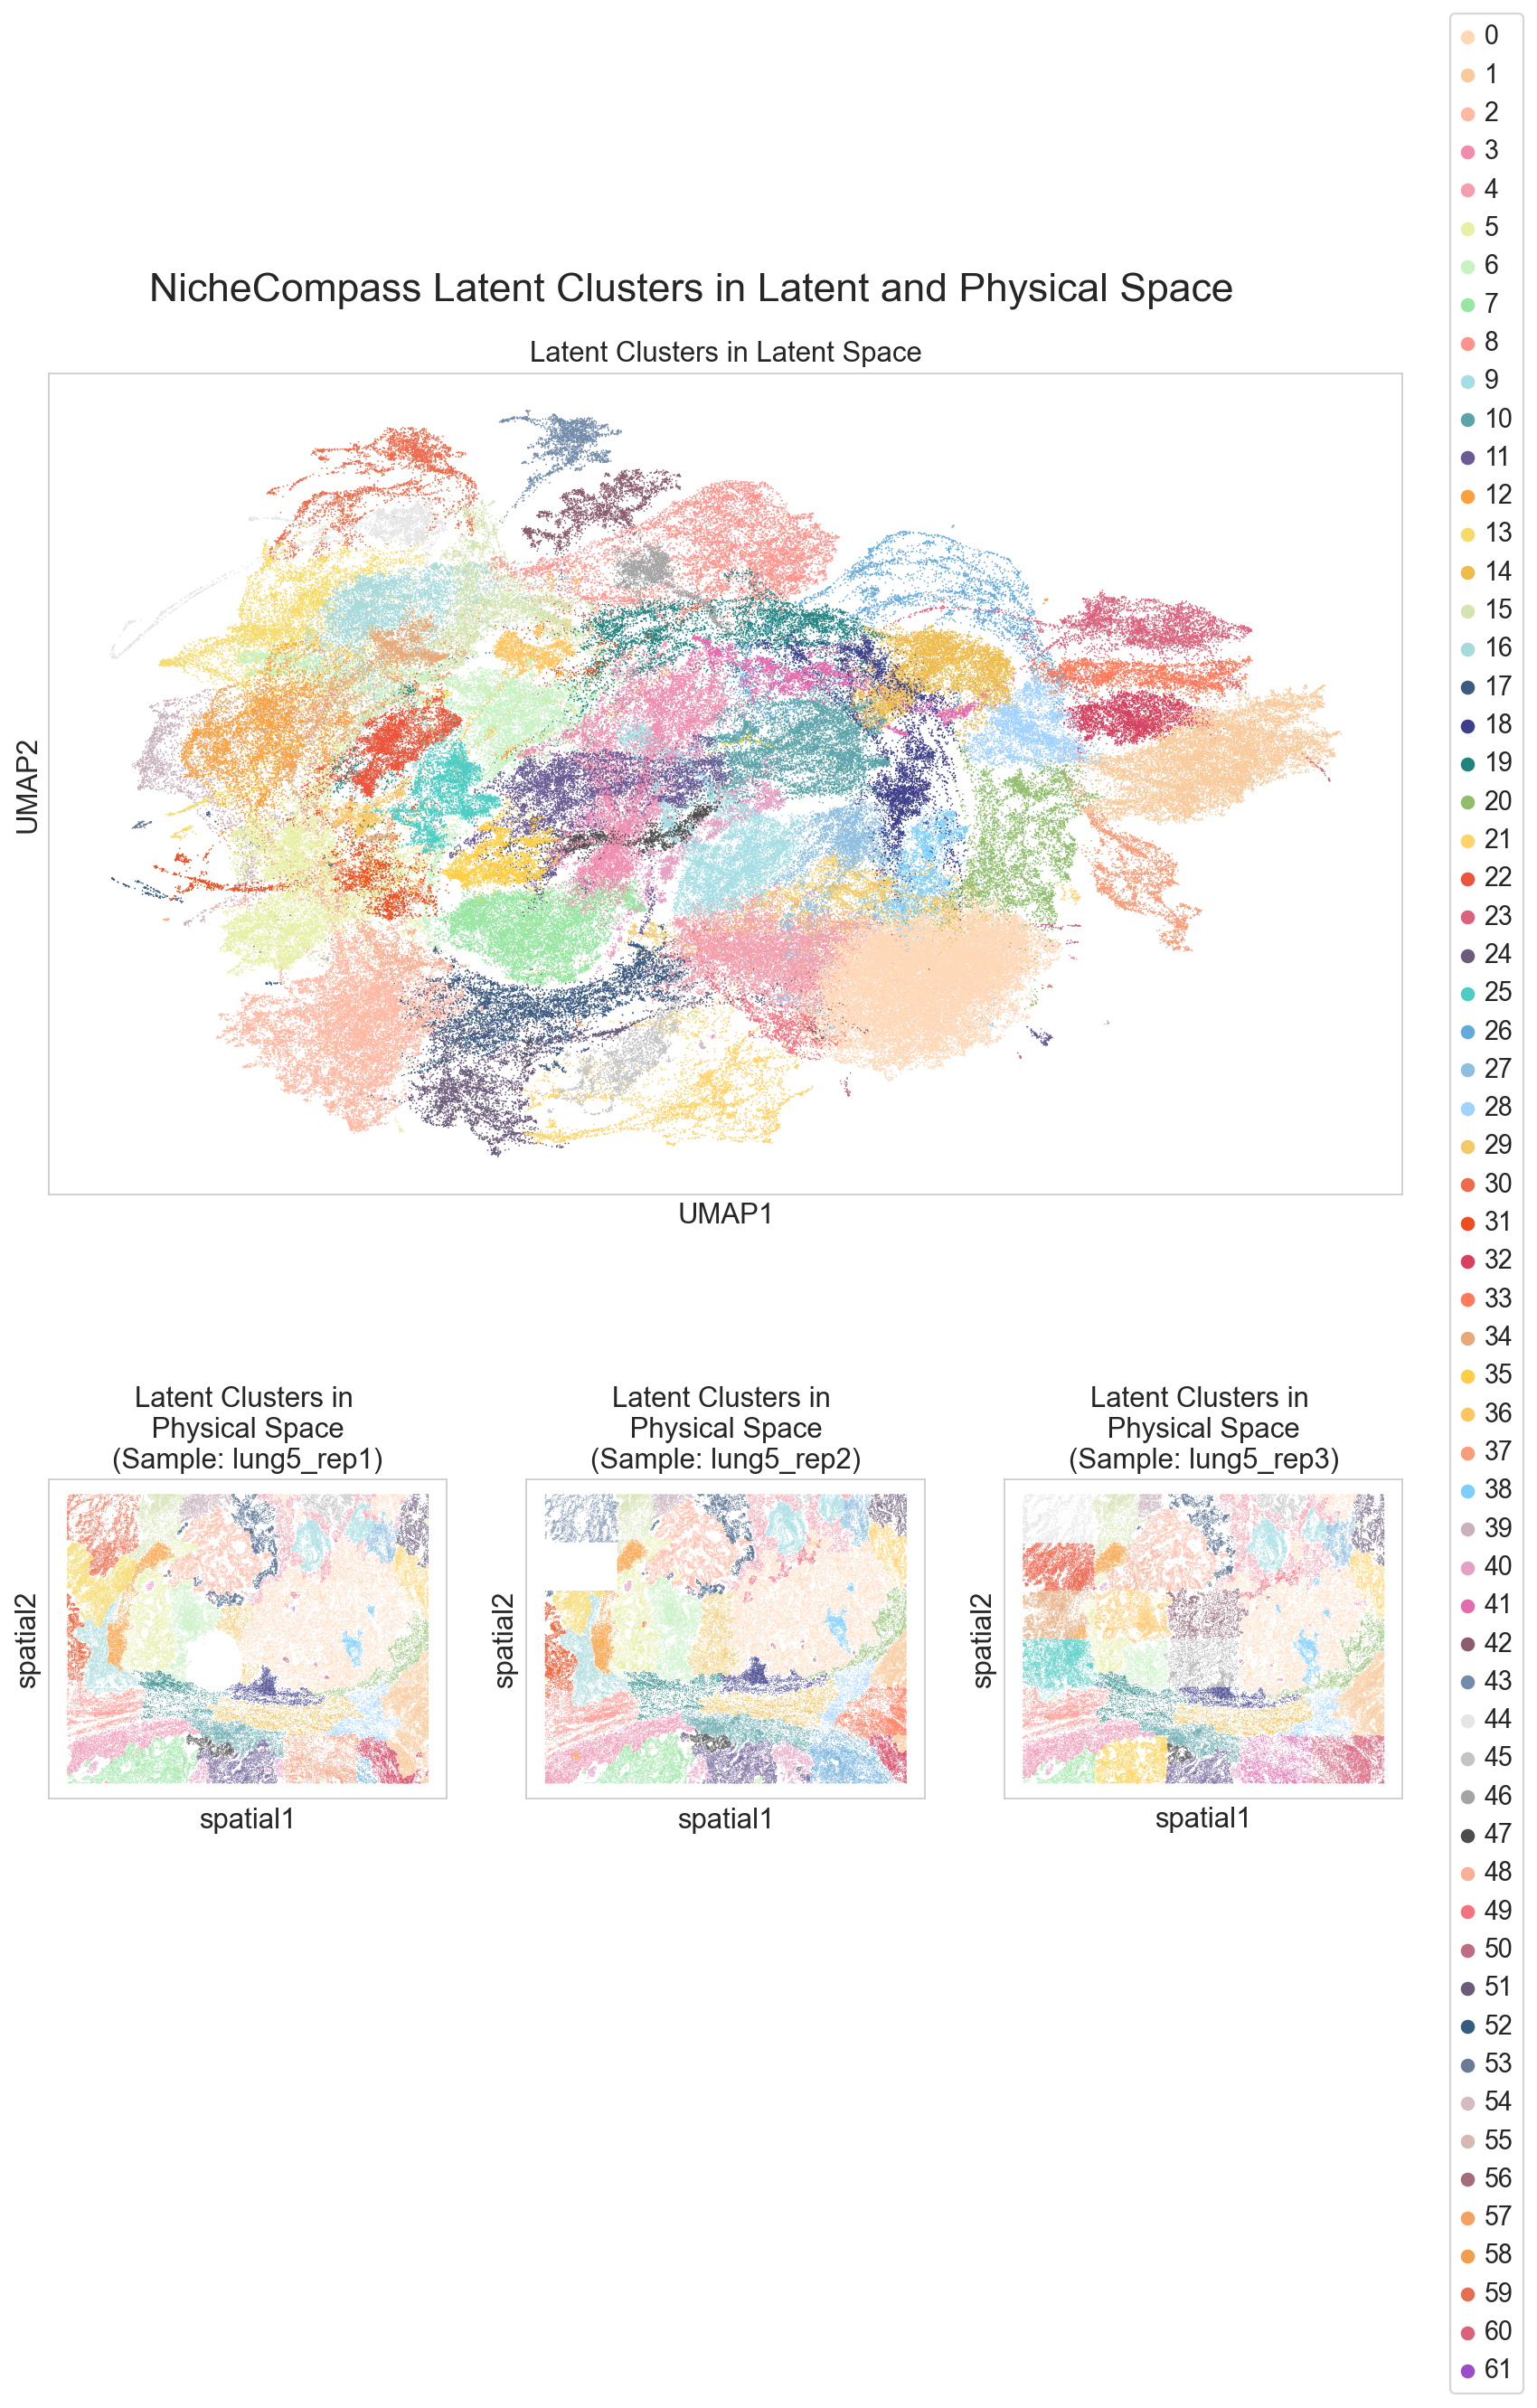

In [23]:
# Latent clusters in latent and physical space
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

plot_latent_clusters_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Latent Clusters",
    latent_cluster_key=latent_cluster_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    latent_cluster_colors=latent_cluster_colors,
    size=640000/len(model.adata),
    spot_size=latent_cluster_spot_size,
    save_fig=save_fig,
    file_path=file_path)

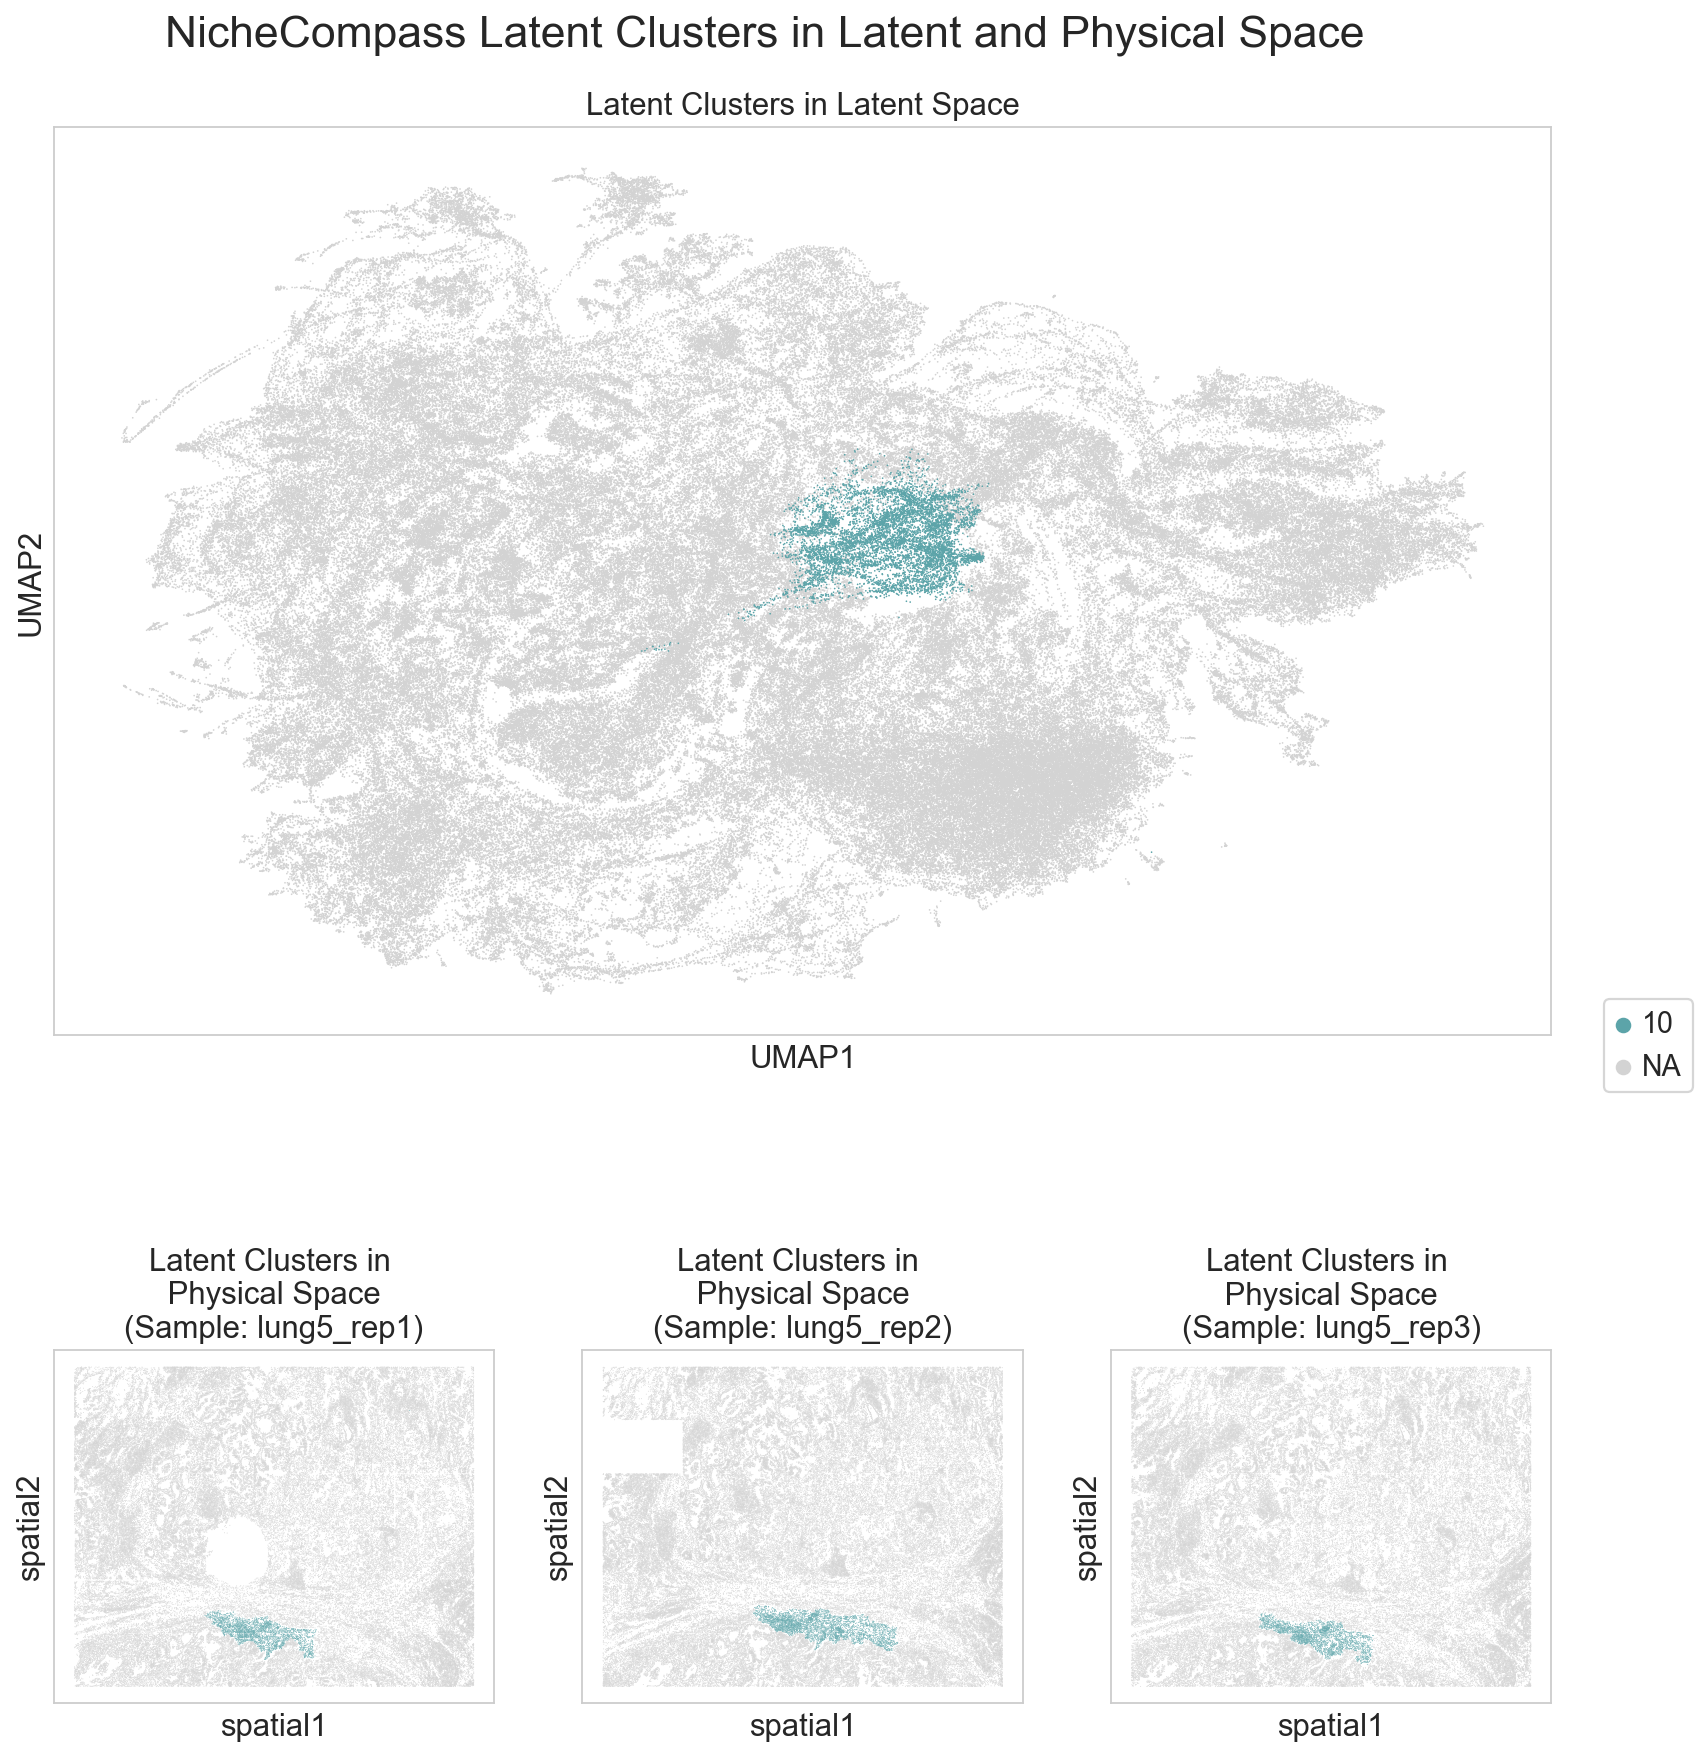

In [24]:
# Selected latent clusters in latent and physical space
groups = ["10"]
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            f"latent_cluster_{'_'.join(groups)}_latent_physical_space.svg"

plot_latent_clusters_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Latent Clusters",
    latent_cluster_key=latent_cluster_key,
    groups=groups,
    sample_key=sample_key,
    samples=samples,
    latent_cluster_colors=latent_cluster_colors,
    size=640000/len(model.adata),
    spot_size=latent_cluster_spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [37]:
model.adata.write('../datasets/srt_data/silver/nanostring_cosmx_human_nsclc/batch123_adata_with_model.h5ad')

In [36]:
model.adata.uns['umap']

{'params': {'a': 0.583030019901822, 'b': 1.3341669931033755}}

In [35]:
model.adata.obsm['spatial'].shape

(282597, 2)

In [30]:
model.adata.obsm['nichecompass_latent'].shape

(282597, 1003)

In [ ]:
model.adata

### 3.2 Analyze GPs & GP Genes

In [ ]:
# Get gp scores of all gps (active & inactive)
latent, _ = model.get_latent_representation(
    adata=model.adata,
    counts_key=counts_key,
    adj_key=adj_key,
    condition_key=condition_key,
    only_active_gps=False,
    return_mu_std=True,
    node_batch_size=model.node_batch_size_)

# Store gp scores, spatial coords and spatial neighbor graph in new adata
gp_adata = ad.AnnData(latent)
gp_adata.obs_names = model.adata.obs_names
gp_adata.var_names = model.adata.uns[gp_names_key]
gp_adata.obs[condition_key] = model.adata.obs[condition_key]
gp_adata.obsp[adj_key] = model.adata.obsp[adj_key]
gp_adata.obsm[spatial_key] = model.adata.obsm[spatial_key]

In [ ]:
# Compute spatial autocorrelation score Moran I of gene programs
# (higher score -> positive spatial autocorrelation)
sq.gr.spatial_autocorr(gp_adata,
                       mode="moran",
                       n_perms=100,
                       n_jobs=1)

# Add score to summary df
gp_summary_df["gp_moranI"] = gp_adata.uns["moranI"].loc[
    gp_summary_df["gp_name"].values.tolist(), "I"].values

In [ ]:
# Plot gp with highest moran I score
sq.pl.spatial_scatter(
    gp_adata[gp_adata.obs[condition_key] == samples[0]],
    shape=None,
    color=[gp_summary_df[["gp_name", "gp_moranI"]].sort_values(by="gp_moranI", ascending=False).head(1)["gp_name"].values[0]],
    size=0.1)

In [ ]:
# Plot gp with lowest moran I score
sq.pl.spatial_scatter(
    gp_adata[gp_adata.obs[condition_key] == samples[0]],
    shape=None,
    color=[gp_summary_df[["gp_name", "gp_moranI"]].sort_values(by="gp_moranI", ascending=False).tail(1)["gp_name"].values[0]],
    size=0.1)

In [ ]:
# Determine highly variable gene programs
hvgp_threshs = [0.1]

hvgp_list = []
hvgp_cols = []
for hvgp_thresh in hvgp_threshs:

    sc.pp.highly_variable_genes(
        gp_adata,
        n_top_genes=int(len(gp_adata.var) * hvgp_thresh),
        flavor="seurat",
        # batch_key=condition_key,
        subset=False)

    hvgp_list.append(gp_adata[:, gp_adata.var["highly_variable"]].var_names.tolist())
    
for i, hvgp_thresh in enumerate(hvgp_threshs):
    gp_summary_df[f"hvgp_{hvgp_thresh}_thresh"] = gp_summary_df["gp_name"].isin(hvgp_list[i])
    hvgp_cols.append(f"hvgp_{hvgp_thresh}_thresh")
    
gp_summary_df.loc[:, "gp_category"] = "inactive"
gp_summary_df.loc[
    gp_summary_df["gp_name"].isin(active_gps), "gp_category"] = "active"
gp_summary_df.loc[
    gp_summary_df["gp_name"].isin(hvgp_list[0]), "gp_category"] = "highly_variable"

In [ ]:
# Retrieve genes, gene importances, gene ranks, and mean gene expr of target and source genes respectively
gp_target_genes_df = gp_summary_df[
    ["gp_name",
     "gp_active",
     "gp_category",
     "gp_moranI",
     "gp_target_genes",
     "gp_target_genes_importances"] +
     hvgp_cols].explode(
        ["gp_target_genes",
         "gp_target_genes_importances"]).rename(
            columns={"gp_target_genes": "target_gene",
                     "gp_target_genes_importances": "target_gene_importance"}).dropna()
gp_target_genes_df["target_gene_rank"] = gp_target_genes_df.groupby("gp_name").cumcount() + 1
gp_target_genes_df["target_gene_importance"] = gp_target_genes_df["target_gene_importance"].astype(np.float32)
gp_target_genes_df["target_gene_mean_log_norm_gene_expr"] = np.array(
    model.adata[:, gp_target_genes_df["target_gene"]].layers[counts_key].mean(0)).flatten()

gp_source_genes_df = gp_summary_df[
    ["gp_name",
     "gp_active",
     "gp_category",
     "gp_moranI",
     "gp_source_genes",
     "gp_source_genes_importances"] +
     hvgp_cols].explode(
        ["gp_source_genes",
         "gp_source_genes_importances"]).rename(
            columns={"gp_source_genes": "source_gene",
                     "gp_source_genes_importances": "source_gene_importance"}).dropna()
gp_source_genes_df["source_gene_rank"] = gp_source_genes_df.groupby("gp_name").cumcount() + 1
gp_source_genes_df["source_gene_importance"] = gp_source_genes_df["source_gene_importance"].astype(np.float32)
gp_source_genes_df["source_gene_mean_log_norm_gene_expr"] = np.array(
    model.adata[:, gp_source_genes_df["source_gene"]].layers[counts_key].mean(0)).flatten()

In [ ]:
# Compute spatial autocorrelation score Moran I of genes
# (higher score -> positive spatial autocorrelation)
genes = list(set(list(gp_target_genes_df["target_gene"]) + list(gp_source_genes_df["source_gene"])))

sq.gr.spatial_autocorr(model.adata,
                       mode="moran",
                       genes=genes,
                       n_perms=100,
                       n_jobs=1)

target_genes_moranI_scores = []
for gene in gp_target_genes_df["target_gene"]:
    target_genes_moranI_scores.append(
        model.adata.uns["moranI"].loc[gene, "I"])
gp_target_genes_df["gene_moranI"] = target_genes_moranI_scores

source_genes_moranI_scores = []
for gene in gp_source_genes_df["source_gene"]:
    source_genes_moranI_scores.append(
        model.adata.uns["moranI"].loc[gene, "I"])
gp_source_genes_df["gene_moranI"] = source_genes_moranI_scores

In [ ]:
# Create summary plots over all gps, active gps, and inactive gps 
# with fixed n_top_genes
n_top_genes = 3
use_only_active_gps = False
    
gp_target_genes_df_top_genes = gp_target_genes_df[
    gp_target_genes_df["target_gene_rank"] <= n_top_genes]
gp_source_genes_df_top_genes = gp_source_genes_df[
    gp_source_genes_df["source_gene_rank"] <= n_top_genes]

all_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes
active_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes[
    gp_target_genes_df_top_genes["gp_active"]]
inactive_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes[
    ~gp_target_genes_df_top_genes["gp_active"]]

all_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes
active_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes[
    gp_source_genes_df_top_genes["gp_active"]]
inactive_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes[
    ~gp_source_genes_df_top_genes["gp_active"]]

# Plot distribution of gene importances
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axs = axs.flatten()
plt.suptitle("Gene Importance Distributions")
sns.histplot(all_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[0],
             bins=20)
axs[0].set(title="Target Genes (All GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(all_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[1],
             bins=20)
axs[1].set(title="Source Genes (All GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
sns.histplot(active_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[2],
             bins=20)
axs[2].set(title="Target Genes (Active GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(active_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[3],
             bins=20)
axs[3].set(title="Source Genes (Active GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
sns.histplot(inactive_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[4],
             bins=20)
axs[4].set(title="Target Genes (Inactive GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(inactive_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[5],
             bins=20)
axs[5].set(title="Source Genes (Inactive GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

# Plot relationship between gene importances and log-normalized gene expression
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between NicheCompass Gene Importances "
             "and Mean Log-Normalized Gene Expression of Genes")
sns.regplot(x=all_gp_target_genes_df_top_genes["target_gene_importance"],
            y=all_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_df_top_genes["target_gene_importance"],
    y=all_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
all_gp_target_genes_r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(all_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=all_gp_source_genes_df_top_genes["source_gene_importance"],
            y=all_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_df_top_genes["source_gene_importance"],
    y=all_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
all_gp_source_genes_r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(all_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=active_gp_target_genes_df_top_genes["target_gene_importance"],
            y=active_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_df_top_genes["target_gene_importance"],
    y=active_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
active_gp_target_genes_r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(active_gp_target_genes_r_squared, 4)};  "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=active_gp_source_genes_df_top_genes["source_gene_importance"],
            y=active_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_df_top_genes["source_gene_importance"],
    y=active_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
active_gp_source_genes_r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(active_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
                y=inactive_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
        y=inactive_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
    inactive_gp_target_genes_r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(inactive_gp_target_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="Gene Importance",
               ylabel="Mean Log-Normalized Gene Expr")
    sns.regplot(x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
                y=inactive_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
        y=inactive_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
    inactive_gp_source_genes_r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(inactive_gp_source_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="Gene Importance",
               ylabel="Mean Log-Normalized Gene Expr")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

# Plot relationship between gene importances and Moran's I score
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between NicheCompass Gene Importances "
             "and Moran's I Scores of Genes")
sns.regplot(x=all_gp_target_genes_df_top_genes["target_gene_importance"],
            y=all_gp_target_genes_df_top_genes["gene_moranI"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
    y=all_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
all_gp_target_genes_r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(all_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=all_gp_source_genes_df_top_genes["source_gene_importance"],
            y=all_gp_source_genes_df_top_genes["gene_moranI"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
    y=all_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
all_gp_source_genes_r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(all_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=active_gp_target_genes_df_top_genes["target_gene_importance"],
            y=active_gp_target_genes_df_top_genes["gene_moranI"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
    y=active_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
active_gp_target_genes_r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(active_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=active_gp_source_genes_df_top_genes["source_gene_importance"],
            y=active_gp_source_genes_df_top_genes["gene_moranI"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
    y=active_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
active_gp_source_genes_r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(active_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
                y=inactive_gp_target_genes_df_top_genes["gene_moranI"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
        y=inactive_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
    inactive_gp_target_genes_r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(inactive_gp_target_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="Gene Importance",
               ylabel="Moran's I Score")
    sns.regplot(x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
                y=inactive_gp_source_genes_df_top_genes["gene_moranI"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
        y=inactive_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
    inactive_gp_source_genes_r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(inactive_gp_source_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="Gene Importance",
               ylabel="Moran's I Score")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

In [ ]:
# Plot relationship between gp moran scores and importance weighted gene moran scores
gp_target_genes_moran_df = gp_target_genes_df.groupby("gp_name").apply(
    lambda x: pd.Series({"weighted_gene_moranI": (
        x["target_gene_importance"] * x["gene_moranI"]).sum()}))
gp_target_genes_moran_df.reset_index(inplace=True)
gp_target_genes_moran_df = pd.merge(gp_target_genes_moran_df,
                                    gp_summary_df[["gp_name", "gp_active", "gp_moranI"]],
                                    on="gp_name")

gp_source_genes_moran_df = gp_source_genes_df.groupby("gp_name").apply(
    lambda x: pd.Series({"weighted_gene_moranI": (
        x["source_gene_importance"] * x["gene_moranI"]).sum()}))
gp_source_genes_moran_df.reset_index(inplace=True)
gp_source_genes_moran_df = pd.merge(gp_source_genes_moran_df,
                                    gp_summary_df[["gp_name", "gp_active", "gp_moranI"]],
                                    on="gp_name")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.flatten()
plt.suptitle("Relationship between GP Moran's I Score and \n"
             "Importance Weighted Gene Moran's I Scores")
sns.scatterplot(data=gp_target_genes_moran_df,
                x=gp_target_genes_moran_df["gp_moranI"],
                y=gp_target_genes_moran_df["weighted_gene_moranI"],
                hue=gp_target_genes_moran_df["gp_active"],
                ax=axs[0])
axs[0].set(title="Target Genes",
           xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.scatterplot(data=gp_source_genes_moran_df,
                x=gp_source_genes_moran_df["gp_moranI"],
                y=gp_source_genes_moran_df["weighted_gene_moranI"],
                hue=gp_source_genes_moran_df["gp_active"],
                ax=axs[1])
axs[1].set(title="Source Genes",
           xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
plt.subplots_adjust(wspace=0.35, top=0.8)
plt.show()

In [ ]:
# Plot relationship between gp moran scores and importance weighted gene moran scores
# across all gps, active gps, and inactive gps

all_gp_target_genes_moran_df = gp_target_genes_moran_df
active_gp_target_genes_moran_df = gp_target_genes_moran_df[
    gp_target_genes_moran_df["gp_active"]]
inactive_gp_target_genes_moran_df = gp_target_genes_moran_df[
    ~gp_target_genes_moran_df["gp_active"]]

all_gp_source_genes_moran_df = gp_source_genes_moran_df
active_gp_source_genes_moran_df = gp_source_genes_moran_df[
    gp_source_genes_moran_df["gp_active"]]
inactive_gp_source_genes_moran_df = gp_source_genes_moran_df[
    ~gp_source_genes_moran_df["gp_active"]]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between GP Moran's I Score and \n"
             "Importance Weighted Gene Moran's I Scores")
sns.regplot(x=all_gp_target_genes_moran_df["gp_moranI"],
            y=all_gp_target_genes_moran_df["weighted_gene_moranI"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_moran_df.dropna()["gp_moranI"],
    y=all_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=all_gp_source_genes_moran_df["gp_moranI"],
            y=all_gp_source_genes_moran_df["weighted_gene_moranI"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_moran_df.dropna()["gp_moranI"],
    y=all_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=active_gp_target_genes_moran_df["gp_moranI"],
            y=active_gp_target_genes_moran_df["weighted_gene_moranI"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_moran_df.dropna()["gp_moranI"],
    y=active_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=active_gp_source_genes_moran_df["gp_moranI"],
            y=active_gp_source_genes_moran_df["weighted_gene_moranI"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_moran_df.dropna()["gp_moranI"],
    y=active_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_moran_df["gp_moranI"],
                y=inactive_gp_target_genes_moran_df["weighted_gene_moranI"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_moran_df.dropna()["gp_moranI"],
        y=inactive_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
    r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="GP Moran's I Score",
               ylabel="Weighted Gene Moran's I Score")
    sns.regplot(x=inactive_gp_source_genes_moran_df["gp_moranI"],
                y=inactive_gp_source_genes_moran_df["weighted_gene_moranI"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_moran_df.dropna()["gp_moranI"],
        y=inactive_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
    r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="GP Moran's I Score",
               ylabel="Weighted Gene Moran's I Score")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

In [ ]:
target_genes_weighted_moran_df = pd.DataFrame(columns=["GP Type", "GP Category", "Weighted Mean Moran's I Score"])
source_genes_weighted_moran_df = pd.DataFrame(columns=["GP Type", "GP Category", "Weighted Mean Moran's I Score"])

for gp_type, gp_type_identifier in zip(["OmniPath", "NicheNet", "MEBOCOST"],
                                       ["receptor", "target", "metabolite"]):
    gp_type_target_genes_df = gp_target_genes_df[gp_target_genes_df["gp_name"].str.contains(gp_type_identifier)]
    gp_type_source_genes_df = gp_source_genes_df[gp_source_genes_df["gp_name"].str.contains(gp_type_identifier)]

    target_genes_weighted_moran_sub_df = gp_type_target_genes_df.groupby("gp_category").apply(
        lambda x: pd.Series({"Weighted Mean Moran's I Score": (
            x["target_gene_importance"] * x["gene_moranI"]).sum() / x["target_gene_importance"].sum()}))

    #new_row = {"Weighted Mean Moran's I Score": gp_type_target_genes_df["moranI"].mean()}
    #index_label = "avg_across_all_gps"
    #new_df = pd.DataFrame(new_row, index=[index_label])
    #target_genes_weighted_moran_sub_df = pd.concat([target_genes_weighted_moran_sub_df,
    #                                              new_df])
    target_genes_weighted_moran_sub_df["GP Type"] = gp_type
    target_genes_weighted_moran_sub_df["GP Category"] = target_genes_weighted_moran_sub_df.index
    target_genes_weighted_moran_sub_df.reset_index(inplace=True)
    
    target_genes_weighted_moran_df = pd.concat([target_genes_weighted_moran_df,
                                                target_genes_weighted_moran_sub_df])

    source_genes_weighted_moran_sub_df = gp_type_source_genes_df.groupby("gp_category").apply(
        lambda x: pd.Series({"Weighted Mean Moran's I Score": (
            x["source_gene_importance"] * x["gene_moranI"]).sum() / x["source_gene_importance"].sum()}))

    #new_row = {"Weighted Mean Moran's I Score": gp_type_source_genes_df["moranI"].mean()}
    #index_label = "avg_across_all_gps"
    #new_df = pd.DataFrame(new_row, index=[index_label])
    #source_genes_weighted_moran_sub_df = pd.concat([source_genes_weighted_moran_sub_df,
    #                                              new_df])
    source_genes_weighted_moran_sub_df["GP Type"] = gp_type
    source_genes_weighted_moran_sub_df["GP Category"] = source_genes_weighted_moran_sub_df.index
    source_genes_weighted_moran_sub_df.reset_index(inplace=True)
    
    source_genes_weighted_moran_df = pd.concat([source_genes_weighted_moran_df,
                                                source_genes_weighted_moran_sub_df])
    
# Plot relationship between gene importances and Moran's I score
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("Mean Moran's I Score Weighted by NicheCompass Gene Importances ")
sns.stripplot(target_genes_weighted_moran_df,
              x="GP Type",
              y="Weighted Mean Moran's I Score",
              hue="GP Category",
              ax=ax1)
ax1.set_title("Target Genes",
              fontsize=14)
ax1.set(xlabel="GP Type",
        ylabel="Weighted Mean Moran's I Score")
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
ax1.get_legend().remove()
sns.stripplot(source_genes_weighted_moran_df,
              x="GP Type",
              y="Weighted Mean Moran's I Score",
              hue="GP Category",
              ax=ax2)
ax2.set_title("Source Genes",
              fontsize=14)
ax2.set(xlabel="GP Type",
        ylabel="Weighted Mean Moran's I Score")
ax2.get_legend().remove()
plt.subplots_adjust(wspace=0.35, top=0.85)
plt.show()

In [ ]:
# Create summary plots with variable n_top_genes
target_genes_corr_df = pd.DataFrame(columns=["Number of Top Genes", "GP Category", "Pearson Correlation"])
source_genes_corr_df = pd.DataFrame(columns=["Number of Top Genes", "GP Category", "Pearson Correlation"])

for n_top_genes in [5, 10, 20, 50, 100]:
    gp_target_genes_df_top_genes = gp_target_genes_df[gp_target_genes_df["target_gene_rank"] <= n_top_genes]
    gp_source_genes_df_top_genes = gp_source_genes_df[gp_source_genes_df["source_gene_rank"] <= n_top_genes]
    
    for gp_category in gp_target_genes_df_top_genes["gp_category"].unique().tolist():
        tmp_cat_df = gp_target_genes_df_top_genes.loc[gp_target_genes_df_top_genes["gp_category"] == gp_category]
        pearsonr = tmp_cat_df["target_gene_importance"].corr(tmp_cat_df["gene_moranI"])
        temp_row_dict = {"Number of Top Genes": n_top_genes,
                         "GP Category": gp_category,
                         "Pearson Correlation": pearsonr}
        target_genes_corr_df = target_genes_corr_df.append(temp_row_dict, ignore_index=True)
        
        tmp_cat_df = gp_source_genes_df_top_genes[gp_source_genes_df_top_genes["gp_category"] == gp_category]
        pearsonr = tmp_cat_df["source_gene_importance"].corr(tmp_cat_df["gene_moranI"])
        temp_row_dict = {"Number of Top Genes": n_top_genes,
                         "GP Category": gp_category,
                         "Pearson Correlation": pearsonr}
        source_genes_corr_df = source_genes_corr_df.append(temp_row_dict, ignore_index=True)
        
# Plot relationship between gene importances and Moran's I score
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("Pearson Correlation between NicheCompass Gene Importances "
             "and Moran's I Scores of Genes")
sns.stripplot(target_genes_corr_df,
              x="Number of Top Genes",
              y="Pearson Correlation",
              hue="GP Category",
              ax=ax1)
ax1.set_title("Target Genes",
              fontsize=14)
ax1.set(xlabel="Number of Top Genes",
        ylabel="Pearson Correlation")
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
ax1.get_legend().remove()
sns.stripplot(source_genes_corr_df,
              x="Number of Top Genes",
              y="Pearson Correlation",
              hue="GP Category",
              ax=ax2)
ax2.set_title("Source Genes",
              fontsize=14)
ax2.set(xlabel="Number of Top Genes",
        ylabel="Pearson Correlation")
ax2.get_legend().remove()
plt.subplots_adjust(wspace=0.35, top=0.85)
plt.show()

### 3.3 Perform Differential GP Testing of Latent Clusters

#### 3.2.1 One vs Rest (All)

##### 3.2.1.1 Decisively Enriched

In [ ]:
selected_cats = None
title = f"NicheCompass Latent Cluster Decisively Enriched Gene Programs"
log_bayes_factor_thresh = 4.6 # decisive threshold (https://en.wikipedia.org/wiki/Bayes_factor)
save_fig = True
file_path = f"{figure_folder_path}/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_latent_clusters_decisively_enriched_gps_dotplot.svg"

# Run differential gp testing
decisively_enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

fig = sc.pl.dotplot(model.adata,
                    decisively_enriched_gps,
                    groupby=latent_cluster_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(decisively_enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = file_path = f"{figure_folder_path}/log_bayes_factor_" \
                        f"{log_bayes_factor_thresh}_latent_clusters_decisively_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]
if multimodal:
    gp_summary_cols = gp_summary_cols + [
        "n_source_peaks",
        "n_target_peaks",
        "gp_source_peaks",
        "gp_target_peaks",
        "gp_source_peaks_weights_sign_corrected",
        "gp_target_peaks_weights_sign_corrected",
        "gp_source_peaks_importances",
        "gp_target_peaks_importances"]

# Get summary of decisively enriched gene programs
decisively_enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(decisively_enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=decisively_enriched_gps, ordered=True)
decisively_enriched_gp_summary_df.loc[:, "gp_name"] = decisively_enriched_gp_summary_df["gp_name"].astype(cat_dtype)
decisively_enriched_gp_summary_df = decisively_enriched_gp_summary_df.sort_values(by="gp_name")
decisively_enriched_gp_summary_df = decisively_enriched_gp_summary_df[gp_summary_cols]

if save_file:
    decisively_enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(decisively_enriched_gp_summary_df)

In [ ]:
generate_gp_info_plots(
    analysis_label=f"latent_clusters",
    model=model,
    cell_type_key=cell_type_key,
    cell_type_colors=cell_type_colors,
    latent_cluster_colors=latent_cluster_colors,
    differential_gp_test_results_key="nichecompass_differential_gp_test_results",
    plot_category=latent_cluster_key,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    plot_types=["top_genes"],
    figure_folder_path=figure_folder_path,
    log_bayes_factor_thresh=log_bayes_factor_thresh,
    save_figs=True)

In [ ]:
generate_gp_info_plots(
    analysis_label=f"latent_clusters",
    model=model,
    cell_type_key=cell_type_key,
    cell_type_colors=cell_type_colors,
    latent_cluster_colors=latent_cluster_colors,
    differential_gp_test_results_key="nichecompass_differential_gp_test_results",
    plot_category=latent_cluster_key,
    feature_spaces=["physical_p22"],
    plot_types=["top_genes"],
    figure_folder_path=figure_folder_path,
    log_bayes_factor_thresh=log_bayes_factor_thresh,
    save_figs=True)

##### 3.2.1.2 Strongly Enriched

In [ ]:
selected_cats = None
title = f"NicheCompass Latent Cluster Strongly Enriched Gene Programs"
log_bayes_factor_thresh = 2.3 # strong threshold (https://en.wikipedia.org/wiki/Bayes_factor)
save_fig = True
file_path = f"{figure_folder_path}/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_latent_clusters_strongly_enriched_gps_dotplot.svg"

# Run differential gp testing
strongly_enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

strongly_enriched_gps = list(set(strongly_enriched_gps) - set(decisively_enriched_gps))

fig = sc.pl.dotplot(model.adata,
                    strongly_enriched_gps,
                    groupby=latent_cluster_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(strongly_enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = file_path = f"{figure_folder_path}/log_bayes_factor_" \
                        f"{log_bayes_factor_thresh}_latent_clusters_strongly_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]
if multimodal:
    gp_summary_cols = gp_summary_cols + [
        "n_source_peaks",
        "n_target_peaks",
        "gp_source_peaks",
        "gp_target_peaks",
        "gp_source_peaks_weights_sign_corrected",
        "gp_target_peaks_weights_sign_corrected",
        "gp_source_peaks_importances",
        "gp_target_peaks_importances"]

# Get summary of strongly enriched gene programs
strongly_enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(strongly_enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=strongly_enriched_gps, ordered=True)
strongly_enriched_gp_summary_df.loc[:, "gp_name"] = strongly_enriched_gp_summary_df["gp_name"].astype(cat_dtype)
strongly_enriched_gp_summary_df = strongly_enriched_gp_summary_df.sort_values(by="gp_name")
strongly_enriched_gp_summary_df = strongly_enriched_gp_summary_df[gp_summary_cols]

if save_file:
    strongly_enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(strongly_enriched_gp_summary_df)

In [ ]:
generate_gp_info_plots(
    analysis_label=f"latent_clusters",
    model=model,
    cell_type_key=cell_type_key,
    cell_type_colors=cell_type_colors,
    latent_cluster_colors=latent_cluster_colors,
    differential_gp_test_results_key="nichecompass_differential_gp_test_results",
    plot_category=latent_cluster_key,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    plot_types=["top_genes"],
    figure_folder_path=figure_folder_path,
    log_bayes_factor_thresh=log_bayes_factor_thresh,
    save_figs=True)

In [ ]:
generate_gp_info_plots(
    analysis_label=f"latent_clusters",
    model=model,
    cell_type_key=cell_type_key,
    cell_type_colors=cell_type_colors,
    latent_cluster_colors=latent_cluster_colors,
    differential_gp_test_results_key="nichecompass_differential_gp_test_results",
    plot_category=latent_cluster_key,
    feature_spaces=["physical_p22"],
    plot_types=["top_genes"],
    figure_folder_path=figure_folder_path,
    log_bayes_factor_thresh=log_bayes_factor_thresh,
    save_figs=True)

#### 3.2.2 One vs Rest (Specific Latent Cluster)

In [ ]:
title = f"NicheCompass Latent Cluster Enriched Gene Programs"
log_bayes_factor_thresh = 2.3 # 2.3, 4.6
save_fig = True
file_path = f"{figure_folder_path}/log_bayes_factor_{log_bayes_factor_thresh}" \
            f"_latent_cluster_{'_'.join(groups)}_enriched_gps_dotplot.svg"

# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=groups,
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=latent_cluster_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = file_path = f"{figure_folder_path}/log_bayes_factor_" \
                        f"{log_bayes_factor_thresh}_latent_cluster_{'_'.join(selected_cats)}_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]
if multimodal:
    gp_summary_cols = gp_summary_cols + [
        "n_source_peaks",
        "n_target_peaks",
        "gp_source_peaks",
        "gp_target_peaks",
        "gp_source_peaks_weights_sign_corrected",
        "gp_target_peaks_weights_sign_corrected",
        "gp_source_peaks_importances",
        "gp_target_peaks_importances"]

# Get summary of enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

### 3.4 Conduct Cell-Type-Level Analysis

#### 3.2.1 Forebrain/Midbrain/Hindbrain

In [715]:
cell_type = "Forebrain/Midbrain/Hindbrain"
cell_type_fmt = cell_type.replace('/', '_').lower()
cell_type_differential_gp_scores_key = f"{cell_type}_differential_gp_scores"

##### 3.2.1.1 Overview

- Regionally specific developing brain subtypes: separation into Rhombencephalon, Tegmentum, Mesencephalon, Prosencephalon

In [ ]:
# Plot cell type in physical and latent space
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=[cell_type],
                                    sample_key=condition_key,
                                    cell_type_key=cell_type_key,
                                    cell_type_colors=seqfish_mouse_organogenesis_cell_type_colors,
                                    figure_folder_path=figure_folder_path,
                                    save_fig=True)

In [ ]:
# Run differential gp testing and generate dotplot of gps enriched in the cell type
title = f"Enriched Gene Programs {cell_type}"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_log_bayes_factor_{log_bayes_factor_thresh}" \
             "_enriched_gps_dotplot.svg"

# Cell type vs other cell types
enriched_gps = model.run_differential_gp_tests(
    cat_key=cell_type_key,
    selected_cats=[cell_type],
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[cell_type_key].nunique()/2.5, len(enriched_gps)/2.5))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = file_path = f"{figure_folder_path}/{cell_type_fmt}_log_bayes_factor_" \
                        f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

# Get summary of enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[[
        "gp_name",
        "n_source_genes",
        "n_non_zero_source_genes",
        "n_target_genes",
        "n_non_zero_target_genes",
        "gp_source_genes",
        "gp_target_genes",
        "gp_source_genes_weights_sign_corrected",
        "gp_target_genes_weights_sign_corrected",
        "gp_source_genes_importances",
        "gp_target_genes_importances"]]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
generate_gp_info_plots(
    analysis_label=f"{cell_type_fmt}",
    model=model,
    cell_type_key=cell_type_key,
    cell_type_colors=cell_type_colors,
    latent_cluster_colors=latent_cluster_colors,
    differential_gp_test_results_key="nichecompass_differential_gp_test_results",
    plot_category=cell_type_key,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    plot_types=["top_genes"],
    figure_folder_path=figure_folder_path,
    log_bayes_factor_thresh=log_bayes_factor_thresh,
    save_figs=True)

##### 3.2.1.2 Latent Cluster Analysis

In [746]:
cell_type_latent_resolution = 0.3 # 0.2 0.4 0.6
cell_type_latent_cluster_key = f"{cell_type_fmt}_latent_leiden_{cell_type_latent_resolution}"
cell_type_latent_clusters_of_interest_key = f"{cell_type_fmt}_latent_leiden_{cell_type_latent_resolution}_clusters_of_interest"
cell_type_latent_cluster_emphasis_key = f"{cell_type_latent_cluster_key}_emphasis"

In [747]:
compute_cell_type_latent_clusters(
    adata=model.adata,
    latent_key=latent_key,
    cell_type_latent_resolution=cell_type_latent_resolution,
    cell_type_latent_cluster_key=cell_type_latent_cluster_key,
    latent_knng_key=latent_key,
    cell_type_key=cell_type_key,
    cell_type=cell_type)

In [ ]:
groups = None
save_fig = True

plot_cell_type_latent_clusters(
    adata=model.adata,
    cell_type_latent_cluster_key=cell_type_latent_cluster_key,
    cell_type=cell_type,
    groups=groups,
    condition_key=sample_key,
    latent_cluster_colors=latent_cluster_colors,
    save_fig=save_fig,
    file_path=f"{figure_folder_path}/{cell_type.replace('/', '_').replace(' ', '_').lower()}"
              f"_res_{cell_type_latent_resolution}_{'latent_clusters' if groups is None else 'latent_cluster_' + groups}"
              "_physical_latent_space.svg")

In [ ]:
# Retrieve cell type latent clusters with at least 'min_obs_per_cluster' observations
min_obs_per_cluster = 100
cell_type_latent_cluster_counts = model.adata.obs[cell_type_latent_cluster_key].value_counts()
cell_type_latent_clusters_of_interest = cell_type_latent_cluster_counts[
    cell_type_latent_cluster_counts > min_obs_per_cluster].index.tolist()

In [ ]:
for latent_cluster in cell_type_latent_clusters_of_interest:
    groups = latent_cluster
    save_fig = True

    plot_cell_type_latent_clusters(
        adata=model.adata,
        cell_type_latent_cluster_key=cell_type_latent_cluster_key,
        cell_type=cell_type,
        groups=groups,
        condition_key=sample_key,
        latent_cluster_colors=latent_cluster_colors,
        save_fig=save_fig,
        file_path=f"{figure_folder_path}/{cell_type.replace('/', '_').replace(' ', '_').lower()}"
                  f"_res_{cell_type_latent_resolution}_{'latent_clusters' if groups is None else 'latent_cluster_' + groups}"
                  "_physical_latent_space.svg")

In [ ]:
# Run differential gp testing and generate dotplot of gps enriched in the cell type
title = f"Enriched Gene Programs {cell_type} Latent Clusters (Resolution: {cell_type_latent_resolution})"
log_bayes_factor_thresh = 2.3 # 2.3, 4.6
save_fig = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_res_{cell_type_latent_resolution}_" \
            f"latent_clusters_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_dotplot.svg"

# Create new column with only clusters of interest for dotplot
model.adata.obs.loc[:, cell_type_latent_clusters_of_interest_key] = np.nan
model.adata.obs.loc[model.adata.obs[cell_type_latent_cluster_key].isin(
    cell_type_latent_clusters_of_interest), cell_type_latent_clusters_of_interest_key] = model.adata.obs[cell_type_latent_cluster_key]

enriched_gps = []
for cell_type_latent_cluster in cell_type_latent_clusters_of_interest:
    
    # Determine comparison categories
    selected_cats = [cell_type_latent_cluster]
    comparison_cats = list(set(cell_type_latent_clusters_of_interest) - set(selected_cats))

    # Latent cluster vs other latent clusters of interest
    latent_cluster_enriched_gps = model.run_differential_gp_tests(
        cat_key=cell_type_latent_cluster_key,
        selected_cats=selected_cats,
        comparison_cats=comparison_cats,
        log_bayes_factor_thresh=log_bayes_factor_thresh)
    
    enriched_gps.extend(latent_cluster_enriched_gps)
    
enriched_gps = list(set(enriched_gps))

fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=cell_type_latent_clusters_of_interest_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[cell_type_latent_clusters_of_interest_key].nunique()/1.5, len(enriched_gps)/2.5))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = file_path = f"{figure_folder_path}/{cell_type_fmt}_res_{cell_type_latent_resolution}" \
                        f"_latent_clusters_" \
                        f"log_bayes_factor_{log_bayes_factor_thresh}_enriched_gps_summary.csv"

# Get summary of enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[[
        "gp_name",
        "n_source_genes",
        "n_non_zero_source_genes",
        "n_target_genes",
        "n_non_zero_target_genes",
        "gp_source_genes",
        "gp_target_genes",
        "gp_source_genes_weights_sign_corrected",
        "gp_target_genes_weights_sign_corrected",
        "gp_source_genes_importances",
        "gp_target_genes_importances"]]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

#### 3.2.2 Cardiomyocytes

In [ ]:
cell_type = "Cardiomyocytes"
cell_type_fmt = cell_type.replace('/', '_').lower()
cell_type_differential_gp_scores_key = f"{cell_type}_differential_gp_scores"

##### 3.2.2.1 Overview

In [ ]:
# Plot cell type in physical and latent space
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=[cell_type],
                                    sample_key=sample_key,
                                    cell_type_key=cell_type_key,
                                    cell_type_colors=seqfish_mouse_organogenesis_cell_type_colors,
                                    figure_folder_path=figure_folder_path,
                                    save_fig=True)

In [ ]:
# Run differential gp testing and generate dotplot of gps enriched in the cell type
title = f"Enriched Gene Programs {cell_type}"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_log_bayes_factor_{log_bayes_factor_thresh}" \
             "_enriched_gps_dotplot.svg"

# Cell type vs other cell types
enriched_gps = model.run_differential_gp_tests(
    cat_key=cell_type_key,
    selected_cats=[cell_type],
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[cell_type_key].nunique()/2.5, len(enriched_gps)/2.5))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = file_path = f"{figure_folder_path}/{cell_type_fmt}_log_bayes_factor_" \
                        f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

# Get summary of enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name"
enriched_gp_summary_df = enriched_gp_summary_df[[
        "gp_name",
        "n_source_genes",
        "n_non_zero_source_genes",
        "n_target_genes",
        "n_non_zero_target_genes",
        "gp_source_genes",
        "gp_target_genes",
        "gp_source_genes_weights_sign_corrected",
        "gp_target_genes_weights_sign_corrected",
        "gp_source_genes_importances",
        "gp_target_genes_importances"]]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
generate_gp_info_plots(
    analysis_label=f"{cell_type_fmt}",
    model=model,
    cell_type_key=cell_type_key,
    cell_type_colors=cell_type_colors,
    latent_cluster_colors=latent_cluster_colors,
    differential_gp_test_results_key="nichecompass_differential_gp_test_results",
    plot_category=cell_type_key,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    plot_types=["top_genes"],
    figure_folder_path=figure_folder_path,
    log_bayes_factor_thresh=log_bayes_factor_thresh,
    save_figs=True)

##### 3.2.2.2 Latent Cluster Analysis

In [ ]:
cell_type_latent_resolution = 0.6 # 0.8 1.0
cell_type_latent_cluster_key = f"{cell_type_fmt}_latent_leiden_{cell_type_latent_resolution}"
cell_type_latent_clusters_of_interest_key = f"{cell_type_fmt}_latent_leiden_{cell_type_latent_resolution}_clusters_of_interest"
cell_type_latent_cluster_emphasis_key = f"{cell_type_latent_cluster_key}_emphasis"

In [ ]:
compute_cell_type_latent_clusters(
    adata=model.adata,
    latent_key=latent_key,
    cell_type_latent_resolution=cell_type_latent_resolution,
    cell_type_latent_cluster_key=cell_type_latent_cluster_key,
    latent_knng_key=latent_key,
    cell_type_key=cell_type_key,
    cell_type=cell_type)

In [ ]:
groups = None
save_fig = True

plot_cell_type_latent_clusters(
    adata=model.adata,
    cell_type_latent_cluster_key=cell_type_latent_cluster_key,
    cell_type=cell_type,
    groups=groups,
    condition_key=sample_key,
    latent_cluster_colors=latent_cluster_colors,
    save_fig=save_fig,
    file_path=f"{figure_folder_path}/{cell_type.replace('/', '_').replace(' ', '_').lower()}"
              f"_res_{cell_type_latent_resolution}_{'latent_clusters' if groups is None else 'latent_cluster_' + groups}"
              "_physical_latent_space.svg")

In [ ]:
# Retrieve cell type latent clusters with at least 'min_obs_per_cluster' observations
min_obs_per_cluster = 30
cell_type_latent_cluster_counts = model.adata.obs[cell_type_latent_cluster_key].value_counts()
cell_type_latent_clusters_of_interest = cell_type_latent_cluster_counts[
    cell_type_latent_cluster_counts > min_obs_per_cluster].index.tolist()

In [ ]:
for latent_cluster in cell_type_latent_clusters_of_interest:
    groups = latent_cluster
    save_fig = True

    plot_cell_type_latent_clusters(
        adata=model.adata,
        cell_type_latent_cluster_key=cell_type_latent_cluster_key,
        cell_type=cell_type,
        groups=groups,
        condition_key=sample_key,
        latent_cluster_colors=latent_cluster_colors,
        save_fig=save_fig,
        file_path=f"{figure_folder_path}/{cell_type.replace('/', '_').replace(' ', '_').lower()}"
                  f"_res_{cell_type_latent_resolution}_{'latent_clusters' if groups is None else 'latent_cluster_' + groups}"
                  "_physical_latent_space.svg")

In [ ]:
# Run differential gp testing and generate dotplot of gps enriched in the cell type
title = f"Enriched Gene Programs {cell_type} Latent Clusters (Resolution: {cell_type_latent_resolution})"
log_bayes_factor_thresh = 2.3 # 2.3, 4.6
save_fig = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_res_{cell_type_latent_resolution}_" \
            f"latent_clusters_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_dotplot.svg"

# Create new column with only clusters of interest for dotplot
model.adata.obs.loc[:, cell_type_latent_clusters_of_interest_key] = np.nan
model.adata.obs.loc[model.adata.obs[cell_type_latent_cluster_key].isin(
    cell_type_latent_clusters_of_interest), cell_type_latent_clusters_of_interest_key] = model.adata.obs[cell_type_latent_cluster_key]

enriched_gps = []
for cell_type_latent_cluster in cell_type_latent_clusters_of_interest:
    
    # Determine comparison categories
    selected_cats = [cell_type_latent_cluster]
    comparison_cats = list(set(cell_type_latent_clusters_of_interest) - set(selected_cats))

    # Latent cluster vs other latent clusters of interest
    latent_cluster_enriched_gps = model.run_differential_gp_tests(
        cat_key=cell_type_latent_cluster_key,
        selected_cats=selected_cats,
        comparison_cats=comparison_cats,
        log_bayes_factor_thresh=log_bayes_factor_thresh)
    
    enriched_gps.extend(latent_cluster_enriched_gps)
    
enriched_gps = list(set(enriched_gps))

fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=cell_type_latent_clusters_of_interest_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[cell_type_latent_clusters_of_interest_key].nunique()/1.5, len(enriched_gps)/2.5))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
save_file = True
file_path = file_path = f"{figure_folder_path}/{cell_type_fmt}_res_{cell_type_latent_resolution}" \
                        f"_latent_clusters_" \
                        f"log_bayes_factor_{log_bayes_factor_thresh}_enriched_gps_summary.csv"

# Get summary of enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[[
        "gp_name",
        "n_source_genes",
        "n_non_zero_source_genes",
        "n_target_genes",
        "n_non_zero_target_genes",
        "gp_source_genes",
        "gp_target_genes",
        "gp_source_genes_weights_sign_corrected",
        "gp_target_genes_weights_sign_corrected",
        "gp_source_genes_importances",
        "gp_target_genes_importances"]]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

#### 3.2.3 Save Results

In [ ]:
model.adata.write(f"{figure_folder_path}/adata.h5ad")

In [ ]:
model.adata

In [ ]:
# Add cell type latent cluster emphasis for plotting
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row,
                                                      cell_type_latent_cluster_key,
                                                      selected_cats,
                                                      comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

In [ ]:
# TO DO HERE

In [ ]:
generate_gp_info_plots(
    analysis_label=f"{cell_type_fmt}_latent_cluster",
    model=model,
    cell_type_key=cell_type_key,
    cell_type_colors=cell_type_colors,
    latent_cluster_colors=latent_cluster_colors,
    differential_gp_test_results_df=model.adata.uns["nichecompass_differential_gp_test_results"],
    plot_category=cell_type_latent_cluster_emphasis_key,
    plot_group=[x for x in model.adata.obs[cell_type_latent_cluster_emphasis_key].unique().tolist() if str(x) != "nan"],
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    figure_folder_path=figure_folder_path,
    save_figs=False)

In [ ]:
# Cell type vs other cell types
enriched_gps = model.run_differential_gp_tests(
    cat_key=cell_type_key,
    selected_cats=[cell_type],
    comparison_cats="rest")

In [ ]:
# Specific latent clusters
cluster_and_plot_cell_type_latent_clusters(adata=model.adata,
                                           cell_type_latent_resolution=cell_type_latent_resolution,
                                           cell_type_latent_cluster_key=cell_type_latent_cluster_key,
                                           latent_knng_key=latent_key,
                                           cell_type_key=cell_type_key,
                                           cell_type=cell_type,
                                           groups=["2"],
                                           latent_cluster_colors=latent_cluster_colors,
                                           condition_key=sample_key,
                                           save_fig=False,
                                           figure_folder_path=figure_folder_path)

In [ ]:
# Retrieve all latent clusters with cells of the given cell type
cell_type_latent_clusters = [cell_type_latent_cluster for cell_type_latent_cluster 
                             in model.adata.obs[cell_type_latent_cluster_key].unique().tolist()
                             if str(cell_type_latent_cluster) != "nan"]

# Define latent clusters of interest according to visualization
cell_type_latent_clusters_of_interest = ["5"]

# Add column with sub cell types
model.adata.obs[sub_cell_type_key] = model.adata.obs.apply(lambda row: add_sub_cell_type(row,
                                                                                         cell_type_key=cell_type_key,
                                                                                         cell_type=cell_type,
                                                                                         cell_type_latent_cluster_key=cell_type_latent_cluster_key), axis=1)
model.adata.obs[sub_cell_type_key] = model.adata.obs[sub_cell_type_key].astype("category")

# Squidpy nhood enrichment is sorted alphabetically
sub_cell_types = model.adata.obs[sub_cell_type_key].unique().tolist()
sub_cell_types.sort()

sq.gr.nhood_enrichment(model.adata, cluster_key=sub_cell_type_key)

cell_type_sub_cell_types_idx = []
for i, sub_cell_type in enumerate(sub_cell_types):
    if cell_type in sub_cell_type:
        cell_type_sub_cell_types_idx.append(i)

        # Retrieve cell type latent cluster neighborhood enrichments
enrichment_dict = {f"{sub_cell_types[cell_type_sub_cell_types_idx[i]]}":{
    sub_cell_type: zscore for zscore, sub_cell_type in sorted(
        zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][cell_type_sub_cell_types_idx[i]], sub_cell_types), reverse=True)} for i in range(len(cell_type_sub_cell_types_idx))}

enrichment_df = pd.DataFrame(enrichment_dict)

In [ ]:
compare_clusters_of_interest_only = False
selected_cats = ["3"]
if compare_clusters_of_interest_only:
    comparison_cats = list(set(cell_type_latent_clusters_of_interest) - set(selected_cats))
else:
    comparison_cats="rest"
latent_cluster_differential_gp_scores_key = f"nichecompass_latent_cluster_{selected_cats[0]}_differential_gp_scores"

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, cell_type_latent_cluster_key, selected_cats[0], comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

top_unique_gps = get_differential_analysis_results(
    analysis_label=f"{cell_type_fmt}_latent_cluster_{selected_cats[0]}",
    model=model,
    adata=model.adata,
    cell_type_key=cell_type_key,
    cell_type_colors=cell_type_colors,
    latent_cluster_colors=latent_cluster_colors,
    random_seed=random_seed,
    cat_key=cell_type_latent_cluster_key,
    selected_cats=selected_cats,
    differential_gp_scores_key=latent_cluster_differential_gp_scores_key,
    comparison_cats=comparison_cats,
    plot_category=cell_type_latent_cluster_emphasis_key,
    plot_group=[x for x in model.adata.obs[cell_type_latent_cluster_emphasis_key].unique().tolist() if str(x) != "nan"],
    selected_gps=None,
    n_top_up_gps=10,
    n_top_down_gps=10,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    figure_folder_path=figure_folder_path,
    save_figs=True)

top_gps_summary_df = store_top_gps_summary(model=model,
                                           top_gps=top_unique_gps,
                                           file_path=f"{figure_folder_path}/{cell_type_fmt}_cluster_{selected_cats[0]}_gp_summary.csv")
display(top_gps_summary_df)

In [ ]:
model.adata

In [ ]:
model.adata.uns["nichecompass_latent_cluster_3_differential_gp_scores"]

In [ ]:
cell_type_latent_cluster_key
save_fig = False

In [ ]:
def create_dotplot_of_differential_gps(adata,
                                       groupby_key,
                                       title,
                                       save_fig,
                                       file_path):
    
    differential_gps = [col for col in model.adata.obs.columns if col.endswith("_GP")]
    
    fig = sc.pl.dotplot(adata,
                        differential_gps,
                        groupby=groupby_key,
                        dendrogram=True, 
                        title=f"Differential GP Scores",
                        swap_axes=True,
                        return_fig=True)
    # Save and display plot
    if save_fig:
        fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.svg")
    fig.show()

In [ ]:
# Retrieve all latent clusters with cells of the given cell type
cell_type_latent_clusters = [cell_type_latent_cluster for cell_type_latent_cluster 
                             in model.adata.obs[cell_type_latent_cluster_key].unique().tolist()
                             if str(cell_type_latent_cluster) != "nan"]

# Define latent clusters of interest according to visualization
cell_type_latent_clusters_of_interest = ["2", "25", "43"]

# Add column with sub cell types
model.adata.obs[sub_cell_type_key] = model.adata.obs.apply(lambda row: add_sub_cell_type(row, cell_type=cell_type), axis=1)
model.adata.obs[sub_cell_type_key] = model.adata.obs[sub_cell_type_key].astype("category")

# Squidpy nhood enrichment is sorted alphabetically
sub_cell_types = model.adata.obs[sub_cell_type_key].unique().tolist()
sub_cell_types.sort()

sq.gr.nhood_enrichment(model.adata, cluster_key=sub_cell_type_key)

cell_type_sub_cell_types_idx = []
for i, sub_cell_type in enumerate(sub_cell_types):
    if cell_type in sub_cell_type:
        cell_type_sub_cell_types_idx.append(i)

        # Retrieve cell type latent cluster neighborhood enrichments
enrichment_dict = {f"{sub_cell_types[cell_type_sub_cell_types_idx[i]]}":{
    sub_cell_type: zscore for zscore, sub_cell_type in sorted(
        zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][cell_type_sub_cell_types_idx[i]], sub_cell_types), reverse=True)} for i in range(len(cell_type_sub_cell_types_idx))}

enrichment_df = pd.DataFrame(enrichment_dict)

In [ ]:
selected_cats = [""]
comparison_cats = list(
    set(cell_type_adata.obs[cell_type_latent_cluster_key].unique()) - set(selected_cats))

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

In [ ]:
get_differential_analysis_results(analysis_label="forebrain_midbrain_hindbrain_latent_cluster",
                                  model=model,
                                  adata=model.adata,
                                  cat_key=cell_type_latent_cluster_key,
                                  selected_cats=selected_cats,
                                  differential_gp_scores_key=latent_cluster_differential_gp_scores_key,
                                  comparison_cats=comparison_cats,
                                  plot_category=cell_type_latent_cluster_emphasis_key,
                                  selected_gps=None,
                                  n_top_up_gps=3,
                                  n_top_down_gps=3,
                                  feature_spaces=["physical_embryo2"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                  save_figs=False)

In [ ]:
model.compute_gp_gene_importances(selected_gp="GDF3_ligand_targetgenes_GP")

In [ ]:
selected_cats = ["7"]
comparison_cats = ["8"]

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

In [ ]:
get_differential_analysis_results(analysis_label="forebrain_midbrain_hindbrain_latent_cluster",
                                  model=model,
                                  adata=model.adata,
                                  cat_key=cell_type_latent_cluster_key,
                                  selected_cats=selected_cats,
                                  differential_gp_scores_key=latent_cluster_differential_gp_scores_key,
                                  comparison_cats=comparison_cats,
                                  plot_category=cell_type_latent_cluster_emphasis_key,
                                  selected_gps=None,
                                  n_top_up_gps=3,
                                  n_top_down_gps=3,
                                  feature_spaces=["physical_embryo2"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
                                  save_figs=False)

### 3.4 Gut Tube

In [ ]:
cell_type = "Gut tube"
cell_type_latent_resolution = 0.04

In [ ]:
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=[cell_type],
                                    save_fig=True)

In [ ]:
cell_type_adata = model.adata[model.adata.obs[cell_type_key] == cell_type.replace("_", " ").capitalize()]

In [ ]:
# Compute latent nearest neighbor graph for cell type only
sc.pp.neighbors(cell_type_adata,
                use_rep=latent_key,
                key_added=f"{cell_type}_latent_knng")

# Compute latent Leiden clustering for cell type
sc.tl.leiden(adata=cell_type_adata,
             resolution=cell_type_latent_resolution,
             random_state=random_seed,
             key_added=cell_type_latent_cluster_key,
             adjacency=cell_type_adata.obsp[f"{cell_type}_latent_knng_connectivities"])

# Use cell type latent space for UMAP generation
sc.tl.umap(cell_type_adata,
           neighbors_key=f"{cell_type}_latent_knng")

In [ ]:
model.adata.obs[cell_type_latent_cluster_key] = np.nan
model.adata.obs.loc[model.adata.obs[cell_type_key] == cell_type.replace("_", " ").capitalize(),
                    cell_type_latent_cluster_key] = cell_type_adata.obs[cell_type_latent_cluster_key]

In [ ]:
plot_latent_physical_for_cell_type_latent_clusters(adata=model.adata,
                                                   cell_type="mixed_mesenchymal_mesoderm",
                                                   save_fig=False)

Dorsal-ventral separation of esophageal and tracheal progenitor populations in the gut tube (not visible in scVI latent space).

Dorsal-ventral and rostral-caudal spatially resolved patterns of the midbrain and hindbrain region.

In [ ]:
model.adata.obsp["nichecompass_recon_adj"] = model.get_recon_adj()

In [ ]:
att_weight_df = aggregate_obsp_matrix_per_cell_type(adata=model.adata,
                                                    obsp_key="nichecompass_agg_alpha",
                                                    cell_type_key=cell_type_key,
                                                    agg_rows=True)

recon_adj_df = aggregate_obsp_matrix_per_cell_type(adata=model.adata,
                                                   obsp_key="nichecompass_recon_adj",
                                                   cell_type_key=cell_type_key,
                                                   agg_rows=True)

adj_df = aggregate_obsp_matrix_per_cell_type(adata=model.adata,
                                             obsp_key="spatial_connectivities",
                                             cell_type_key=cell_type_key,
                                             agg_rows=True)

In [ ]:
create_cell_type_chord_plot_from_df(adata=model.adata,
                                    df=att_weight_df,
                                    title="Aggregation Module Cell Type Attention",
                                    link_threshold=.5,
                                    cell_type_key=cell_type_key,
                                    save_fig=True,
                                    save_path=f"{model_artifacts_folder_path}/circos.png")

#### 3.2.1 Cardiomyocytes

In [ ]:
cell_type = "Cardiomyocytes"
cell_type_fmt = cell_type.replace('/', '_').lower()
cell_type_latent_resolution = 1.0
cell_type_latent_cluster_key = f"{cell_type_fmt}_latent_leiden_{cell_type_latent_resolution}"
cell_type_latent_cluster_emphasis_key = f"{cell_type_latent_cluster_key}_emphasis"
cell_type_differential_gp_scores_key = f"{cell_type}_differential_gp_scores"

In [ ]:
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=[cell_type],
                                    sample_key=sample_key,
                                    cell_type_key=cell_type_key,
                                    cell_type_colors=seqfish_mouse_organogenesis_cell_type_colors,
                                    figure_folder_path=figure_folder_path,
                                    save_fig=False)

In [ ]:
top_unique_gps = get_differential_analysis_results(
    analysis_label=cell_type_fmt,
    model=model,
    adata=model.adata,
    cell_type_key=cell_type_key,
    cell_type_colors=cell_type_colors,
    cat_key=cell_type_key,
    selected_cats=[cell_type],
    differential_gp_scores_key=cell_type_differential_gp_scores_key,
    comparison_cats="rest",
    plot_category=cell_type_key,
    plot_group=cell_type,
    selected_gps=None,
    n_top_up_gps=10,
    n_top_down_gps=10,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    save_figs=False,
    random_seed=random_seed)

top_gps_summary_df = store_top_gps_summary(model=model,
                                           top_gps=top_unique_gps,
                                           file_path=f"{model_artifacts_folder_path}/{cell_type_fmt}_gp_summary.csv")
display(top_gps_summary_df)

In [ ]:
# Compute latent Leiden clustering with cell-type-specific resolution
sc.tl.leiden(adata=model.adata,
             resolution=cell_type_latent_resolution,
             random_state=random_seed,
             key_added=cell_type_latent_cluster_key,
             neighbors_key=latent_key)

# Filter for cell type
cell_type_adata = model.adata[model.adata.obs[cell_type_key] == cell_type]

# Only keep latent clusters for cell type and set rest to NaN
model.adata.obs[cell_type_latent_cluster_key] = np.nan
model.adata.obs.loc[model.adata.obs[cell_type_key] == cell_type,
                    cell_type_latent_cluster_key] = cell_type_adata.obs[cell_type_latent_cluster_key]

In [ ]:
plot_latent_physical_for_cell_type_latent_clusters(adata=model.adata,
                                                   cell_type=cell_type,
                                                   save_fig=False)

In [ ]:
# Retrieve all latent clusters with cells of the given cell type
cell_type_latent_clusters = [cell_type_latent_cluster for cell_type_latent_cluster 
                             in model.adata.obs[cell_type_latent_cluster_key].unique().tolist()
                             if str(cell_type_latent_cluster) != "nan"]

# Define latent clusters of interest according to visualization
cell_type_latent_clusters_of_interest = ["2", "25", "43"]

# Add column with sub cell types
model.adata.obs[sub_cell_type_key] = model.adata.obs.apply(lambda row: add_sub_cell_type(row, cell_type=cell_type), axis=1)
model.adata.obs[sub_cell_type_key] = model.adata.obs[sub_cell_type_key].astype("category")

# Squidpy nhood enrichment is sorted alphabetically
sub_cell_types = model.adata.obs[sub_cell_type_key].unique().tolist()
sub_cell_types.sort()

sq.gr.nhood_enrichment(model.adata, cluster_key=sub_cell_type_key)

cell_type_sub_cell_types_idx = []
for i, sub_cell_type in enumerate(sub_cell_types):
    if cell_type in sub_cell_type:
        cell_type_sub_cell_types_idx.append(i)

        # Retrieve cell type latent cluster neighborhood enrichments
enrichment_dict = {f"{sub_cell_types[cell_type_sub_cell_types_idx[i]]}":{
    sub_cell_type: zscore for zscore, sub_cell_type in sorted(
        zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][cell_type_sub_cell_types_idx[i]], sub_cell_types), reverse=True)} for i in range(len(cell_type_sub_cell_types_idx))}

enrichment_df = pd.DataFrame(enrichment_dict)

#### 3.2.1 Latent Cluster 2

In [ ]:
selected_cats = ["2"]
comparison_cats = list(set(cell_type_latent_clusters_of_interest) - set(selected_cats))
latent_cluster_differential_gp_scores_key = f"nichecompass_latent_cluster_{selected_cats[0]}_differential_gp_scores"

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

top_unique_gps = get_differential_analysis_results(
    analysis_label=f"{cell_type}_latent_cluster",
    model=model,
    adata=model.adata,
    cat_key=cell_type_latent_cluster_key,
    selected_cats=selected_cats,
    differential_gp_scores_key=latent_cluster_differential_gp_scores_key,
    comparison_cats=comparison_cats,
    plot_category=cell_type_latent_cluster_emphasis_key,
    plot_group=[x for x in model.adata.obs[cell_type_latent_cluster_emphasis_key].unique().tolist() if str(x) != "nan"],
    selected_gps=None,
    n_top_up_gps=10,
    n_top_down_gps=10,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    save_figs=False)

top_gps_summary_df = store_top_gps_summary(model=model,
                                           top_gps=top_unique_gps,
                                           file_name=f"{cell_type_fmt}_cluster{selected_cats[0]}_gp_summary.csv")
display(top_gps_summary_df)

#### 3.2.2 Latent Cluster 25

In [ ]:
selected_cats = ["25"]
comparison_cats = list(set(cell_type_latent_clusters_of_interest) - set(selected_cats))
latent_cluster_differential_gp_scores_key = f"nichecompass_latent_cluster_{selected_cats[0]}_differential_gp_scores"

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

top_unique_gps = get_differential_analysis_results(
    analysis_label=f"{cell_type}_latent_cluster",
    model=model,
    adata=model.adata,
    cat_key=cell_type_latent_cluster_key,
    selected_cats=selected_cats,
    differential_gp_scores_key=latent_cluster_differential_gp_scores_key,
    comparison_cats=comparison_cats,
    plot_category=cell_type_latent_cluster_emphasis_key,
    plot_group=[x for x in model.adata.obs[cell_type_latent_cluster_emphasis_key].unique().tolist() if str(x) != "nan"],
    selected_gps=None,
    n_top_up_gps=10,
    n_top_down_gps=10,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    save_figs=False)

top_gps_summary_df = store_top_gps_summary(model=model,
                                           top_gps=top_unique_gps,
                                           file_name=f"{cell_type_fmt}_cluster{selected_cats[0]}_gp_summary.csv")
display(top_gps_summary_df)

#### 3.2.3 Latent Cluster 43

In [ ]:
selected_cats = ["43"]
comparison_cats = list(set(cell_type_latent_clusters_of_interest) - set(selected_cats))
latent_cluster_differential_gp_scores_key = f"nichecompass_latent_cluster_{selected_cats[0]}_differential_gp_scores"

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

top_unique_gps = get_differential_analysis_results(
    analysis_label=f"{cell_type}_latent_cluster",
    model=model,
    adata=model.adata,
    cat_key=cell_type_latent_cluster_key,
    selected_cats=selected_cats,
    differential_gp_scores_key=latent_cluster_differential_gp_scores_key,
    comparison_cats=comparison_cats,
    plot_category=cell_type_latent_cluster_emphasis_key,
    plot_group=[x for x in model.adata.obs[cell_type_latent_cluster_emphasis_key].unique().tolist() if str(x) != "nan"],
    selected_gps=None,
    n_top_up_gps=10,
    n_top_down_gps=10,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    save_figs=False)

top_gps_summary_df = store_top_gps_summary(model=model,
                                           top_gps=top_unique_gps,
                                           file_name=f"{cell_type_fmt}_cluster{selected_cats[0]}_gp_summary.csv")
display(top_gps_summary_df)

In [ ]:
top_gps = [model.adata.uns[f"nichecompass_latent_cluster_{latent_cluster}_differential_gp_scores"]["gene_program"][:n_top_up_gps].tolist() + 
           model.adata.uns[f"nichecompass_latent_cluster_{latent_cluster}_differential_gp_scores"]["gene_program"][-n_top_down_gps:].tolist()
           for latent_cluster in cell_type_latent_clusters_of_interest]

top_gps = [gp for gp_list in top_gps for gp in gp_list]

for gp in top_gps:
    cell_type_adata.obs[gp] = model.adata.obs.loc[model.adata.obs[cell_type_latent_cluster_key].notnull(), gp]

In [ ]:
fig = sc.pl.dotplot(cell_type_adata,
            top_gps,
            groupby=cell_type_latent_cluster_key,
            dendrogram=True, 
            title="Mixed Mesenchymal Mesoderm Latent Clusters Differential GP Scores",
            swap_axes=True,
            ax=ax1,
            return_fig=True)
title = fig.suptitle(t=f"asd",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec = gridspec.GridSpec(ncols=2,
                         nrows=1,
                         width_ratios=[1, 1],
                         height_ratios=[1])
ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[0])

#ax2 = sns.heatmap(enrichment_df, annot=True, fmt=".2f", cmap="viridis", ax=ax2)
plt.show()

In [ ]:
axs = sc.pl.heatmap(cell_type_adata,
                   top_gps,
                   groupby=cell_type_latent_cluster_key,
                   cmap="viridis",
                   dendrogram=True,
                   swap_axes=True,
                   figsize=(12, 12),
                   show=False)
fig = axs["heatmap_ax"].get_figure()
fig.subplots_adjust(left=0.4)
spec = matplotlib.gridspec.GridSpec(ncols=2, nrows=1, right=2.2)
ax2 = fig.add_subplot(spec[1])
sns.heatmap(enrichment_df, annot=True, fmt=".2f", cmap="viridis", ax=ax2)
ax2.set_title("Neighborhood enrichments")

In [ ]:
fig = sc.pl.dotplot(cell_type_adata,
                    top_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title=f"{cell_type_fmt} Latent Clusters Differential GP Scores",
                    cmap="magma",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
#if save_figs:
#    fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
fig.show()

In [ ]:
# Retrieve summary information for top gene programs
cell_type_gp_df = gp_summary_df[gp_summary_df["gp_name"].isin(top_gps)][[
    "gp_name",
    "n_source_genes",
    "n_non_zero_source_genes",
    "n_target_genes",
    "n_non_zero_target_genes",
    "gp_source_genes",
    "gp_target_genes",
    "gp_source_genes_weights_sign_corrected",
    "gp_target_genes_weights_sign_corrected",
    "gp_source_genes_importances",
    "gp_target_genes_importances"]]

# Write to disk
cell_type_gp_df.to_csv(f"{model_artifacts_folder_path}/cell_type_gp_df.csv")
display(cell_type_gp_df)

#### 3.2.4 Cardiomyocytes vs Endothelium

Cardiomyocytes are spatially and morphologically distinct from other cell types, endothelium is interspersed and spread across the entire embryo space.

In [ ]:
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=["Cardiomyocytes", "Endothelium"],
                                    save_fig=True)

### 3.3 Mixed Mesenchymal Mesoderm

"mixed mesenchymal mesoderm, represent 
a cell state rather than a defined cell type. Mesenchyme represents  a  state  in  which  cells  express  markers  characteristic  of  migratory   cells loosely dispersed within an extracellular matrix56. This strong  overriding transcriptional signature of mesenchyme, irrespective of  location,  makes  it  challenging  to  distinguish  which  cell  types  this   mixed  mesenchymal  mesoderm  population  represents  using  clas- sical scRNA-seq data"

We can identify distinct subpopulations that are spatially defined.

In [ ]:
cell_type = "Mixed mesenchymal mesoderm"
cell_type_fmt = cell_type.replace(' ', '_').lower()
cell_type_latent_resolution = 0.5 # 0.5
cell_type_latent_cluster_key = f"{cell_type_fmt}_latent_leiden_{cell_type_latent_resolution}"
cell_type_latent_cluster_emphasis_key = f"{cell_type_latent_cluster_key}_emphasis"
cell_type_differential_gp_scores_key = f"{cell_type}_differential_gp_scores"

In [ ]:
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=["Mixed mesenchymal mesoderm"],
                                    save_fig=False)

In [ ]:
top_unique_gps = get_differential_analysis_results(
    analysis_label=cell_type_fmt,
    model=model,
    adata=model.adata,
    cat_key=cell_type_key,
    selected_cats=[cell_type],
    differential_gp_scores_key=cell_type_differential_gp_scores_key,
    comparison_cats="rest",
    plot_category=cell_type_key,
    plot_group=cell_type,
    selected_gps=None,
    n_top_up_gps=10,
    n_top_down_gps=10,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    save_figs=False)

top_gps_summary_df = store_top_gps_summary(model=model,
                                           top_gps=top_unique_gps,
                                           file_name=f"{cell_type_fmt}_gp_summary.csv")
display(top_gps_summary_df)

In [ ]:
# Compute latent Leiden clustering with cell-type-specific resolution
sc.tl.leiden(adata=model.adata,
             resolution=cell_type_latent_resolution,
             random_state=random_seed,
             key_added=cell_type_latent_cluster_key,
             neighbors_key=latent_key)

# Filter for cell type
cell_type_adata = model.adata[model.adata.obs[cell_type_key] == cell_type]

# Only keep latent clusters for cell type and set rest to NaN
model.adata.obs[cell_type_latent_cluster_key] = np.nan
model.adata.obs.loc[model.adata.obs[cell_type_key] == cell_type,
                    cell_type_latent_cluster_key] = cell_type_adata.obs[cell_type_latent_cluster_key]

In [ ]:
plot_latent_physical_for_cell_type_latent_clusters(adata=model.adata,
                                                   cell_type=cell_type,
                                                   save_fig=False)

In [ ]:
fig = sc.pl.umap(
    model.adata,
    color=f"{cell_type_fmt}_latent_leiden_{cell_type_latent_resolution}",
    palette=latent_cluster_colors,
    groups="11",
    size=2560000/len(model.adata),
    return_fig=True)
fig.set_size_inches(15, 10)

In [ ]:
# Retrieve all latent clusters with cells of the given cell type
cell_type_latent_clusters = [cell_type_latent_cluster for cell_type_latent_cluster 
                             in model.adata.obs[cell_type_latent_cluster_key].unique().tolist()
                             if str(cell_type_latent_cluster) != "nan"]

# Define latent clusters of interest according to visualization
cell_type_latent_clusters_of_interest = ["1", "22", "16", "13", "20", "24"]

# Add column with sub cell types
model.adata.obs[sub_cell_type_key] = model.adata.obs.apply(lambda row: add_sub_cell_type(row, cell_type=cell_type), axis=1)
model.adata.obs[sub_cell_type_key] = model.adata.obs[sub_cell_type_key].astype("category")

# Squidpy nhood enrichment is sorted alphabetically
sub_cell_types = model.adata.obs[sub_cell_type_key].unique().tolist()
sub_cell_types.sort()

sq.gr.nhood_enrichment(model.adata, cluster_key=sub_cell_type_key)

cell_type_sub_cell_types_idx = []
for i, sub_cell_type in enumerate(sub_cell_types):
    if cell_type in sub_cell_type:
        cell_type_sub_cell_types_idx.append(i)

        # Retrieve cell type latent cluster neighborhood enrichments
enrichment_dict = {f"{sub_cell_types[cell_type_sub_cell_types_idx[i]]}":{
    sub_cell_type: zscore for zscore, sub_cell_type in sorted(
        zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][cell_type_sub_cell_types_idx[i]], sub_cell_types), reverse=True)} for i in range(len(cell_type_sub_cell_types_idx))}

enrichment_df = pd.DataFrame(enrichment_dict)

#### 3.3.1 Latent Cluster 1

In [ ]:
selected_cats = ["1"]
comparison_cats = list(set(cell_type_latent_clusters_of_interest) - set(selected_cats))
latent_cluster_differential_gp_scores_key = f"nichecompass_latent_cluster_{selected_cats[0]}_differential_gp_scores"

model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs.apply(
    lambda row: add_cell_type_latent_cluster_emphasis(row, comparison_cats), axis=1)
model.adata.obs[cell_type_latent_cluster_emphasis_key] = model.adata.obs[cell_type_latent_cluster_emphasis_key].astype("category")

top_unique_gps = get_differential_analysis_results(
    analysis_label=f"{cell_type}_latent_cluster",
    model=model,
    adata=model.adata,
    cat_key=cell_type_latent_cluster_key,
    selected_cats=selected_cats,
    differential_gp_scores_key=latent_cluster_differential_gp_scores_key,
    comparison_cats=comparison_cats,
    plot_category=cell_type_latent_cluster_emphasis_key,
    plot_group=[x for x in model.adata.obs[cell_type_latent_cluster_emphasis_key].unique().tolist() if str(x) != "nan"],
    selected_gps=None,
    n_top_up_gps=10,
    n_top_down_gps=10,
    feature_spaces=["latent"], # "physical_embryo1", "physical_embryo2", "physical_embryo3"
    save_figs=False)

top_gps_summary_df = store_top_gps_summary(model=model,
                                           top_gps=top_unique_gps,
                                           file_name=f"{cell_type_fmt}_cluster{selected_cats[0]}_gp_summary.csv")
display(top_gps_summary_df)

#### Overview

In [ ]:
model.adata.obs.loc[model.adata.obs[cell_type_latent_cluster_key] == "0", "MPZ_ligand_targetgenes_GP"].mean()

In [ ]:
model.adata.obs.loc[model.adata.obs[cell_type_latent_cluster_key] == "1", "MPZ_ligand_targetgenes_GP"].mean()

In [ ]:
model.adata.obs.loc[model.adata.obs[cell_type_latent_cluster_key] == "2", "MPZ_ligand_targetgenes_GP"].mean()

In [ ]:
model.adata.obs.loc[model.adata.obs[cell_type_latent_cluster_key] == "3", "MPZ_ligand_targetgenes_GP"].mean()

In [ ]:
sq.pl.nhood_enrichment(model.adata, cluster_key=sub_cell_type_key)

In [ ]:
enrichment_dict = {f"{i}":{
    cell_type: zscore for zscore, cell_type in sorted(
        zip(model.adata.uns[f"{sub_cell_type_key}_nhood_enrichment"]["zscore"][15 + i], cell_types), reverse=True)} for i in range(4)}

enrichment_df = pd.DataFrame(enrichment_dict)

In [ ]:
top_gps = [model.adata.uns[f"nichecompass_latent_cluster_{latent_cluster}_differential_gp_scores"]["gene_program"][:n_top_up_gps].tolist() + 
           model.adata.uns[f"nichecompass_latent_cluster_{latent_cluster}_differential_gp_scores"]["gene_program"][-n_top_down_gps:].tolist()
           for latent_cluster in [cell_type_latent_cluster for cell_type_latent_cluster in model.adata.obs[cell_type_latent_cluster_key].unique().tolist() if str(cell_type_latent_cluster) != "nan"]]

top_gps = [gp for gp_list in top_gps for gp in gp_list]

for gp in top_gps:
    cell_type_adata.obs[gp] = model.adata.obs.loc[model.adata.obs[cell_type_latent_cluster_key].notnull(), gp]

In [ ]:
axs = sc.pl.heatmap(cell_type_adata,
                   top_gps,
                   groupby=cell_type_latent_cluster_key,
                   cmap="viridis",
                   dendrogram=True,
                   swap_axes=True,
                   figsize=(12, 12),
                   show=False)
fig = axs["heatmap_ax"].get_figure()
fig.subplots_adjust(left=0.4)
spec = matplotlib.gridspec.GridSpec(ncols=2, nrows=1, right=2.2)
ax2 = fig.add_subplot(spec[1])
sns.heatmap(enrichment_df, annot=True, fmt=".2f", cmap="viridis", ax=ax2)
ax2.set_title("Neighborhood enrichments")

In [ ]:
fig = sc.pl.dotplot(cell_type_adata,
                    top_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title="Mixed Mesenchymal Mesoderm Latent Clusters Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
# Save and display plot
#if save_figs:
#    fig.savefig(f"{figure_folder_path}/{analysis_label}_differential_gp_scores.png")
plt.show()

In [ ]:
fig = sc.pl.dotplot(cell_type_adata,
                    top_gps,
                    groupby=cell_type_latent_cluster_key,
                    dendrogram=True, 
                    title="Mixed Mesenchymal Mesoderm Latent Clusters Differential GP Scores",
                    swap_axes=True,
                    return_fig=True)
fig.show()

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.heatmap(enrichment_df, annot=True, ax=ax2)
ax2.set_title("Neighborhood enrichments")

In [ ]:
fig

### 3.5 CellRank